# Truora

# 1 Author

**Student Name**:  Zheyun Zhao

**Student ID**:  221170559



# 2 Problem Description

In this mini-project, the mission is addressing a crucial task—determining whether a narrated story is **True** using machine learning techniques. Specifically, the goal is to develop a predictive model that can accurately classify audio stories lasting **3 to 5 minutes** as either **True** or **Deception**.

### Problem Statement

The core problem is to perform binary classification on audio data to determine whether a given narrated story is **True** or **Deception**. This task involves extracting and analyzing acoustic features from audio recordings to identify patterns associated with deceptive narratives. The challenge lies in effectively capturing subtle variations and features in the audio that distinguish genuine from fabricated stories.

### Importance and Interest

Deception detection in verbal communication holds significant importance, with applications spanning security, law enforcement, psychology, and human-computer interaction. Unlike text-based analysis, audio-based deception detection leverages prosodic features of speech, such as intonation, speaking rate, and pauses, which provide richer information beyond the linguistic content.

The interest in this problem stems from the fact that deceptive behavior often manifests in subtle speech variations, which even trained human observers may find challenging to detect. Through machine learning models, the objective is to automate and enhance the accuracy of deception detection, thereby offering more reliable and scalable solutions for real-world applications.

---

# 3 Methodology

The approach encompasses a comprehensive pipeline integrating data preprocessing, feature extraction, model training, ensemble model construction, evaluation, and prediction. The methodology is designed to effectively transform raw audio data into meaningful representations and leverage multiple machine learning models, including an ensemble approach, to achieve accurate classification.

### Training and Validation Tasks

1. **Data Preprocessing and Augmentation:**
   - **Data Loading:** Utilize the `DataTransformer` class to load and manage the dataset, including both original and augmented audio recordings.
   - **Data Augmentation:** Enhance the dataset's diversity and robustness through techniques such as time stretching, pitch shifting, noise addition, and volume alteration.

2. **Feature Extraction:**
   - Extract a rich set of acoustic features from each audio recording, including Mel-Spectrogram, MFCC, Chroma, Zero Crossing Rate (ZCR), Spectral Centroid, Spectral Rolloff, Spectral Flux, Short-Term Energy, and Duration.
   - Concatenate these features into a unified feature matrix, ensuring consistent dimensions through padding or truncation.

3. **Model Training:**
   - Implement various machine learning models, including **Neural Networks** (CNN-LSTM with Attention), **Random Forests**, **K-Nearest Neighbors**, **Logistic Regression**, and **Support Vector Machines**.
   - Train each model using the extracted features and corresponding labels, employing appropriate hyperparameters and training configurations.
   
4. **Ensemble Model Construction:**
   - In addition to individual models, an ensemble model is built to aggregate predictions from multiple base models, including **Neural Networks**, **Random Forest**, **K-Nearest Neighbors**, **Logistic Regression**, and **Support Vector Machines**.
   - **Weighted Allocating via Logistic Regression:** The ensemble model uses **Logistic Regression** to combine the prediction probabilities from the five base models, where the weights are dynamically learned based on training data. This allows the ensemble model to adjust the contribution of each base model based on its individual performance.
   - **Training the Ensemble Model:** During training, the ensemble model collects the predictions from each of the base models, uses these predictions as new features, and then fits the Logistic Regression meta-classifier to learn optimal weights for each base model.
   - This process improves the final prediction accuracy by leveraging the strengths of individual models while mitigating their weaknesses.

5. **Validation:**
   - Evaluate model performance on an independent validation set to monitor overfitting and adjust hyperparameters.
   - Utilize callbacks like **learning rate scheduling**, **early stopping**, and **model checkpointing** to optimize the training process.
   - The performance of both individual models and the ensemble model is evaluated to assess the impact of the ensemble approach on classification accuracy.

### Model Performance Metrics

To comprehensively evaluate model performance, the evaluation employs a suite of evaluation metrics:

- **Accuracy:** Measures the proportion of correctly classified instances out of the total instances.
- **Confusion Matrix:** Provides detailed classification information, including true positives, true negatives, false positives, and false negatives, facilitating the analysis of specific classification errors.
- **Class-sensitive rates**
  - **Sensitivity (Recall):** Reflects the model's ability to identify all relevant positive instances.
  - **Specificity:** Indicates the model's capacity to identify all relevant negative instances.
  - **Precision:** Assesses the accuracy of positive class predictions.
- **F1 Score:** Balances precision and recall, offering a harmonic mean of the two.
- **ROC Curve and AUC:** Evaluates the trade-off between true positive rate and false positive rate, with AUC serving as an aggregate measure of performance.

These metrics offer a comprehensive perspective on the models' effectiveness, enabling a deep understanding of their overall performance and specific strengths and weaknesses in the context of deception detection.

---

# 4 Implemented Machine Learning Prediction Pipeline

The machine learning prediction pipeline is divided into several stages: Transformation, Model Training, and Ensemble. Each stage is meticulously designed to handle data processing, model training, and prediction aggregation to achieve optimal classification performance.

### Overview

1. **Transformation Stage:**
   - **Input:** Raw audio files.
   - **Output:** Extracted and processed feature matrix.
   - **Process:** Data loading, augmentation, feature extraction, and preprocessing.

2. **Model Stage:**
   - **Input:** Feature matrix and corresponding labels.
   - **Output:** Trained machine learning models.
   - **Process:** Construction, training, and saving of various models (NN, RF, KNN, LR, SVM).

3. **Ensemble Stage:**
   - **Input:** Prediction results from individual models.
   - **Output:** Aggregated final prediction.
   - **Process:** Weighted allocation of prediction probabilities to enhance overall performance.

---

### Some Basic Configuration

In [12]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from typing import List, Tuple, Dict, Any, Optional
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)

In [13]:
class Config:
    """
    Configuration class for setting up dataset paths, labels, model parameters, and training configurations.

    Attributes:
        train_dataset (str): Path to the training dataset.
        validation_dataset (str): Path to the validation dataset.
        test_dataset (str): Path to the test dataset.
        labels (List[str]): List of label names.
        model_path (str): Directory path to save and load models.
        epochs (int): Number of training epochs.
        batch_size (int): Size of each training batch.
    """

    train_dataset: str
    validation_dataset: str 
    test_dataset: str
    labels: List[str]
    model_path: str
    epochs: int
    batch_size: int

    def __init__(
        self,
        train_dataset: str = "../datasets/train.npz",
        validation_dataset: str = "../datasets/validation.npz", 
        test_dataset: str = "../datasets/test.npz",
        labels: List[str] = ["True Story", "Deceptive Story"],
        model_path: str = "../models/",
        epochs: int = 100,
        batch_size: int = 10,
    ):
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.test_dataset = test_dataset
        self.labels = labels
        self.model_path = model_path
        self.epochs = epochs
        self.batch_size = batch_size

## 4.1 Transformation stage

#### Description

The Transformation Stage is pivotal in converting raw audio data into a structured format amenable to machine learning algorithms. This stage involves data loading, augmentation to enhance dataset diversity, and comprehensive feature extraction to capture relevant acoustic characteristics.

#### Input and Output

- **Input:** 
  - **Raw Audio Files:** Original audio recordings of narrated stories.
  - **Metadata:** Attributes such as Language and Story Type from the CSV file.

- **Output:** 
  - **Feature Matrices:** Structured numerical representations of audio features.
  - **Labels:** Encoded story types indicating truthfulness.

#### Feature Extraction Techniques

1. **Mel-Spectrogram:** Represents the short-term power spectrum of sound, emphasizing perceptually relevant frequencies.
2. **MFCC (Mel-Frequency Cepstral Coefficients):** Captures the timbral aspects of audio, widely used in speech and audio processing.
3. **Chroma Features:** Reflect the energy distribution across different pitch classes, capturing harmonic and melodic characteristics.
4. **Zero-Crossing Rate (ZCR):** Measures the frequency of sign changes in the audio signal, indicative of noisiness or speech rhythm.
5. **Spectral Centroid and Rolloff:** Provide insights into the brightness and frequency distribution of the audio.
6. **Spectral Flux:** Quantifies the rate of change in the power spectrum, capturing dynamic aspects of the audio.
7. **Short-Term Energy and Duration:** Measure the energy content and length of the audio signal, providing temporal context.

#### Rationale

The selection of these features is motivated by their proven effectiveness in capturing various facets of audio signals pertinent to deception detection. By aggregating these diverse features, the Transformation Stage ensures a comprehensive representation of the audio data, facilitating the extraction of subtle cues associated with truthful or deceptive storytelling.

---

In [14]:
import librosa

class DataTransformer:
  """
  Handles data loading and feature extraction for audio datasets.

  Attributes:
      config (Config): Configuration object containing dataset paths and parameters.
  """
  def __init__(self, config: Config) -> None:
    """
    Initializes the DataTransformer with the given configuration.

    Args:
        config (Config): Configuration object.
    """
    self.config: Config = config

  @staticmethod
  def load_data_from_npz(file_path: str) -> np.ndarray:
    """
    Loads data from a .npz file.

    Args:
        file_path (str): Path to the .npz file.

    Returns:
        np.ndarray: Loaded data.
    """
    data = np.load(file_path)
    return data

  def get_datasets(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Retrieves training, validation, and test datasets.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
            Tuple containing features and labels for training, validation, and test sets.
    """
    train_data = self.load_data_from_npz(self.config.train_dataset)
    validation_data = self.load_data_from_npz(self.config.validation_dataset)
    test_data = self.load_data_from_npz(self.config.test_dataset)
    return train_data["features"], train_data["labels"], validation_data["features"], validation_data["labels"], test_data["features"], test_data["labels"]
      
  @staticmethod
  def extract_features(
      file_path: str,
      sr: int = 16000,
      n_mels: int = 128,
      duration: int = 240,
  ) -> np.ndarray:
    """
    Extracts audio features from a given file, including Mel-Spectrogram, MFCC, Chroma, ZCR, energy, duration,
    spectral centroid, spectral rolloff, and spectral flux. All features are concatenated into a single matrix
    with fixed length processing.

    Args:
        file_path (str): Path to the audio file.
        sr (int, optional): Sampling rate. Defaults to 16000.
        n_mels (int, optional): Number of Mel bands. Defaults to 128.
        duration (int, optional): Duration of the audio in seconds. Defaults to 240.

    Returns:
        np.ndarray: Extracted and concatenated features.
    """
    audio, sr = librosa.load(file_path, sr=sr)

    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)

    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    short_term_energy = np.sum(audio ** 2) / len(audio)
    duration_feature = len(audio) / sr

    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85)
    spectral_flux = librosa.onset.onset_strength(y=audio, sr=sr)

    features = np.vstack([
        log_mel_spectrogram,
        mfcc,
        chroma,
        zero_crossing_rate,
        spectral_centroid,
        spectral_rolloff,
        spectral_flux,
    ])

    target_length = int(sr * duration / 512)
    if features.shape[1] < target_length:
      padding = np.zeros((features.shape[0], target_length - features.shape[1]))
      features = np.concatenate([features, padding], axis=1)
    else:
      features = features[:, :target_length]

    additional_features = np.array([short_term_energy, duration_feature])
    additional_features = np.repeat(additional_features[:, np.newaxis], features.shape[1], axis=1)

    features = np.concatenate([features, additional_features], axis=0)

    return features

## 4.2 Model stage

#### Description

The Model Stage encompasses the construction, training, and evaluation of multiple machine learning models, each leveraging different algorithms and architectures to capture distinct patterns in the data. The diversity of models aims to harness varied strengths, contributing to a robust predictive system.

#### Implemented Models

1. **Neural Networks (CNN-LSTM with Attention):**
   - **Architecture:** Combines Convolutional Neural Networks (CNNs) for spatial feature extraction and Long Short-Term Memory (LSTM) networks for temporal sequence modeling, enhanced with an Attention mechanism.
   - **Rationale:** Capable of capturing complex patterns in high-dimensional data and focusing on relevant temporal segments, making it well-suited for processing audio features.

2. **Random Forest Classifier:**
   - **Algorithm:** Ensemble of decision trees, leveraging bagging and feature randomness to improve predictive accuracy and control overfitting.
   - **Rationale:** Robust to overfitting, handles high-dimensional data well, and provides feature importance insights.

3. **K-Nearest Neighbors (KNN) Classifier:**
   - **Algorithm:** Instance-based learning that classifies based on the majority label of the nearest neighbors in the feature space.
   - **Rationale:** Simple and effective for certain classification tasks, providing a non-parametric approach that can adapt to data nuances.

4. **Logistic Regression (LR) Classifier:**
   - **Algorithm:** Linear model for binary classification, estimating probabilities using the logistic function.
   - **Rationale:** Provides a baseline for comparison, interpretable coefficients, and effectiveness in linearly separable scenarios.

5. **Support Vector Machine (SVM) Classifier:**
   - **Algorithm:** Maximizes the margin between classes using kernel functions to handle non-linear separations.
   - **Rationale:** Powerful in high-dimensional spaces, effective with clear margins of separation, and versatile with different kernel choices.

#### Rationale for Model Selection

The selection of these models is driven by their complementary strengths and widespread adoption in classification tasks:

- **Neural Networks:** Offer high flexibility and capacity to model complex relationships in data.
- **Random Forests and SVMs:** Provide robust performance and are effective in handling various data distributions.
- **KNN and Logistic Regression:** Serve as strong baselines and offer simplicity and interpretability.

By integrating these diverse models, the pipeline aims to capture a wide spectrum of data characteristics, enhancing the overall predictive performance through ensemble techniques.

---

### Base Model

In [15]:
from abc import ABC, abstractmethod


class BaseModel(ABC):
    """
    Abstract base class for models, supporting lifecycle management and core functionality.
    """

    def __init__(self) -> None:
        """
        Initializes the BaseModel with default settings.
        """
        self.use: bool = True
        self.model: Optional[Any] = None

    @abstractmethod
    def build(self, **kwargs: Any) -> None:
        """
        Build the model architecture.

        Args:
            **kwargs: Additional keyword arguments for building the model.
        """
        pass

    @abstractmethod
    def train(self, X_train: Any, y_train: Any, **kwargs: Any) -> None:
        """
        Train the model on the provided data.

        Args:
            X_train (Any): Training features.
            y_train (Any): Training labels.
            **kwargs: Additional keyword arguments for training.
        """
        pass

    @abstractmethod
    def predict(self, X_test: Any) -> Any:
        """
        Generate predictions for the provided test data.

        Args:
            X_test (Any): Test features.

        Returns:
            Any: Predictions.
        """
        pass

    @abstractmethod
    def save(self, path: str) -> None:
        """
        Save the model to the specified path.

        Args:
            path (str): File path to save the model.
        """
        pass

    @abstractmethod
    def load(self, path: str) -> None:
        """
        Load the model from the specified path.

        Args:
            path (str): File path to load the model from.
        """
        pass

    def get(self) -> Optional[Any]:
        """
        Retrieve the model instance if enabled.

        Returns:
            Optional[Any]: The model instance or None if disabled.
        """
        return self.model if self.use else None

    def enable(self) -> None:
        """
        Enable the model for use.
        """
        self.use = True

    def disable(self) -> None:
        """
        Disable the model from being used.
        """
        self.use = False

### Neural Networks Model (CNN-LSTM with Attention)

In [16]:
import os
from keras import layers, models, callbacks

def show_history(history: callbacks.History) -> None:
    """
    Plots the training and validation accuracy and loss over epochs.

    Args:
        history: History object returned by model.fit().
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

class NNModel(BaseModel):
    """
    Neural Network model using CNN-LSTM architecture with Attention mechanism.
    """
    def __init__(self) -> None:
        """
        Initializes the NNModel.
        """
        super().__init__()

    def build(self, input_shape: Tuple[int, int, int]) -> models.Model:
        """
        Builds the CNN-LSTM model architecture.

        Args:
            input_shape (Tuple[int, int, int]): Shape of the input data.

        Returns:
            models.Model: Compiled Keras model.
        """
        model_input = layers.Input(shape=input_shape)

        x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(model_input)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.4)(x)

        x = layers.Reshape((1, 128))(x)  # (batch_size, sequence_length=1, feature_dim=128)
        attention_output = layers.Attention()([x, x])  # Self-Attention

        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(attention_output)
        x = layers.Bidirectional(layers.LSTM(64))(x)

        x = layers.Dense(64, activation="relu", kernel_regularizer="l2")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        output = layers.Dense(1, activation="sigmoid")(x)

        model = models.Model(inputs=model_input, outputs=output)
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        self.model = model
        return self.model

    def train(self, X_train: Any, y_train: Any, x_val: Any, y_val: Any, model_path: str, epochs: int = 10, batch_size: int = 32) -> models.Model:
        """
        Trains the Neural Network model.

        Args:
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training labels.
            x_val (np.ndarray): Validation features.
            y_val (np.ndarray): Validation labels.
            model_path (str): Path to save the best model.
            epochs (int, optional): Number of training epochs. Defaults to 10.
            batch_size (int, optional): Batch size for training. Defaults to 32.

        Returns:
            models.Model: Trained Keras model.
        """
        print(f"Training Neural Network ...")

        lr_scheduler = callbacks.ReduceLROnPlateau(
            monitor="val_accuracy",
            factor=0.5,
            patience=10,
            min_lr=1e-6
        )
        early_stopping = callbacks.EarlyStopping(monitor="val_accuracy", patience=100)
        model_checkpoint = callbacks.ModelCheckpoint(
            filepath=os.path.join(model_path, f"nn_model.keras"),
            monitor="val_accuracy",
            save_best_only=True
        )
        callbacks_list = [lr_scheduler, early_stopping, model_checkpoint]

        history = self.model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
            callbacks=callbacks_list
        )
        show_history(history)

        return self.model

    def predict(self, X_test: Any) -> Any:
        """
        Generates predictions for the test data.

        Args:
            X_test (np.ndarray): Test features.

        Returns:
            np.ndarray: Flattened prediction probabilities.
        """
        return self.model.predict(X_test).flatten()

    def save(self, path: str) -> None:
        """
        Saves the model to the specified path.

        Args:
            path (str): Path to save the model.
        """
        self.model.save(path)

    def load(self, path: str) -> models.Model:
        """
        Loads the model from the specified path.

        Args:
            path (str): Path to load the model from.

        Returns:
            models.Model: Loaded Keras model.
        """
        self.model = models.load_model(path)
        return self.model

### Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier

class RFModel(BaseModel):
    """
    Random Forest Classifier model.
    """
    def __init__(self) -> None:
        """
        Initializes the RFModel.
        """
        super().__init__()

    def build(self, n_estimators: int = 100, random_state: int = 42) -> RandomForestClassifier:
        """
        Builds the Random Forest model.

        Args:
            n_estimators (int, optional): Number of trees in the forest. Defaults to 100.
            random_state (int, optional): Random state for reproducibility. Defaults to 42.

        Returns:
            RandomForestClassifier: Initialized Random Forest model.
        """
        self.model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
        return self.model

    def train(self, X_train: np.ndarray, y_train) -> RandomForestClassifier:
        """
        Trains the Random Forest model.

        Args:
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training labels.

        Returns:
            RandomForestClassifier: Trained Random Forest model.
        """
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_train_2d, y_train)
        return self.model

    def predict(self, X_test) -> np.ndarray:
        """
        Generates prediction probabilities for the test data.

        Args:
            X_test (np.ndarray): Test features.

        Returns:
            np.ndarray: Probability of the positive class.
        """
        X_test_2d = X_test.reshape(X_test.shape[0], -1)
        return self.model.predict_proba(X_test_2d)[:, 1]

    def save(self, path: str) -> None:
        """
        Saves the Random Forest model to the specified path.

        Args:
            path (str): Path to save the model.
        """
        joblib.dump(self.model, path)

    def load(self, path: str) -> RandomForestClassifier:
        """
        Loads the Random Forest model from the specified path.

        Args:
            path (str): Path to load the model from.

        Returns:
            RandomForestClassifier: Loaded Random Forest model.
        """
        self.model = joblib.load(path)
        return self.model

### K Nearest Neighbors Classifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier

class KNNModel(BaseModel):
    """
    K-Nearest Neighbors Classifier model.
    """
    def __init__(self) -> None:
        """
        Initializes the KNNModel.
        """
        super().__init__()

    def build(self, n_neighbors: int = 5) -> KNeighborsClassifier:
        """
        Builds the KNN model.

        Args:
            n_neighbors (int, optional): Number of neighbors to use. Defaults to 5.

        Returns:
            KNeighborsClassifier: Initialized KNN model.
        """
        self.model = KNeighborsClassifier(n_neighbors=n_neighbors)
        return self.model

    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> KNeighborsClassifier:
        """
        Trains the KNN model.

        Args:
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training labels.

        Returns:
            KNeighborsClassifier: Trained KNN model.
        """
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_train_2d, y_train)
        return self.model

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Generates predictions for the test data.

        Args:
            X_test (np.ndarray): Test features.

        Returns:
            np.ndarray: Predicted class labels.
        """
        X_test_2d = X_test.reshape(X_test.shape[0], -1)
        return self.model.predict(X_test_2d)

    def save(self, path: str) -> None:
        """
        Saves the KNN model to the specified path.

        Args:
            path (str): Path to save the model.
        """
        joblib.dump(self.model, path)

    def load(self, path: str) -> KNeighborsClassifier:
        """
        Loads the KNN model from the specified path.

        Args:
            path (str): Path to load the model from.

        Returns:
            KNeighborsClassifier: Loaded KNN model.
        """
        self.model = joblib.load(path)
        return self.model

### Logistic Regression Classifier

In [19]:
from sklearn.linear_model import LogisticRegression

class LRModel(BaseModel):
    """
    Logistic Regression Classifier model.
    """

    def __init__(self) -> None:
        """
        Initializes the LRModel.
        """
        super().__init__()

    def build(self, C: float = 1.0, random_state: int = 42, max_iter: int = 100) -> LogisticRegression:
        """
        Builds the Logistic Regression model.

        Args:
            C (float, optional): Inverse of regularization strength. Defaults to 1.0.
            random_state (int, optional): Random state for reproducibility. Defaults to 42.
            max_iter (int, optional): Maximum number of iterations. Defaults to 100.

        Returns:
            LogisticRegression: Initialized Logistic Regression model.
        """
        self.model = LogisticRegression(C=C, random_state=random_state, max_iter=max_iter)
        return self.model

    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> LogisticRegression:
        """
        Trains the Logistic Regression model.

        Args:
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training labels.

        Returns:
            LogisticRegression: Trained Logistic Regression model.
        """
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_train_2d, y_train)
        return self.model

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Generates prediction probabilities for the test data.

        Args:
            X_test (np.ndarray): Test features.

        Returns:
            np.ndarray: Probability of the positive class.
        """
        X_test_2d = X_test.reshape(X_test.shape[0], -1)
        return self.model.predict_proba(X_test_2d)[:, 1]

    def save(self, path: str) -> None:
        """
        Saves the Logistic Regression model to the specified path.

        Args:
            path (str): Path to save the model.
        """
        joblib.dump(self.model, path)

    def load(self, path: str) -> LogisticRegression:
        """
        Loads the Logistic Regression model from the specified path.

        Args:
            path (str): Path to load the model from.

        Returns:
            LogisticRegression: Loaded Logistic Regression model.
        """
        self.model = joblib.load(path)
        return self.model

### Support Vector Machine Classifier

In [20]:
from sklearn.svm import SVC

class SVM(BaseModel):
    """
    Support Vector Machine Classifier model.
    """

    def __init__(self) -> None:
        """
        Initializes the SVM model.
        """
        super().__init__()

    def build(self, C: float = 1.0, kernel: str = 'rbf') -> SVC:
        """
        Builds the SVM model.

        Args:
            C (float, optional): Regularization parameter. Defaults to 1.0.
            kernel (str, optional): Kernel type to be used in the algorithm. Defaults to 'rbf'.

        Returns:
            SVC: Initialized SVM model.
        """
        self.model = SVC(C=C, kernel=kernel, probability=True)
        return self.model

    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> SVC:
        """
        Trains the SVM model.

        Args:
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training labels.

        Returns:
            SVC: Trained SVM model.
        """
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_train_2d, y_train)
        return self.model

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Generates predictions for the test data.

        Args:
            X_test (np.ndarray): Test features.

        Returns:
            np.ndarray: Predicted class labels.
        """
        X_test_2d = X_test.reshape(X_test.shape[0], -1)
        return self.model.predict(X_test_2d)

    def save(self, path: str) -> None:
        """
        Saves the SVM model to the specified path.

        Args:
            path (str): Path to save the model.
        """
        joblib.dump(self.model, path)

    def load(self, path: str) -> SVC:
        """
        Loads the SVM model from the specified path.

        Args:
            path (str): Path to load the model from.

        Returns:
            SVC: Loaded SVM model.
        """
        self.model = joblib.load(path)
        return self.model

### ModelBuilder: A Comprehensive Model Construction Framework

The `ModelBuilder` class is designed to facilitate the construction of various machine learning models, providing a standardized interface for model creation. It encapsulates the process of building different types of models, allowing the user to easily instantiate and configure the desired model.

Currently, `ModelBuilder` supports the construction of the following models:

1. **Neural Network (CNN-LSTM with Attention)**: 
   - This model leverages Convolutional Neural Networks (CNN) combined with Long Short-Term Memory (LSTM) layers and Attention mechanisms, ideal for processing sequential data like audio. 
   - The `build_nn_model` method is used to instantiate and configure the model.

2. **Random Forest (RF)**:
   - A robust ensemble method that builds multiple decision trees and merges them to improve classification accuracy and control overfitting.
   - The `build_rf_model` method is responsible for creating and configuring the Random Forest model, allowing the specification of the number of trees and the random state for reproducibility.

3. **K-Nearest Neighbors (KNN)**:
   - A simple yet effective model based on the distance between data points. The model classifies data by looking at the 'k' nearest neighbors.
   - The `build_knn_model` method provides an easy way to configure the number of neighbors used for the model.

4. **Logistic Regression (LR)**:
   - A widely used linear model for binary and multi-class classification tasks, ideal for establishing relationships between features and class probabilities.
   - The `build_logistic_regression_model` method allows configuration of the regularization strength, maximum iterations, and random state.

5. **Support Vector Machine (SVM)**:
   - A powerful classifier that finds the optimal hyperplane for separating data points of different classes. It can work effectively in high-dimensional spaces.
   - The `build_svm_model` method is used to build the SVM, with options to configure the regularization parameter and kernel type.

Each model construction method is highly customizable, allowing users to set specific hyperparameters to suit their data and task. The flexibility and ease of use provided by the `ModelBuilder` class streamline the process of selecting and configuring the appropriate model for the task at hand.


In [21]:
class ModelBuilder:
    """
    Responsible for constructing and returning the required models.
    Currently includes CNN-LSTM model (with Attention) and various traditional machine learning models.
    """

    @staticmethod
    def build_nn_model(input_shape: Tuple[int, int, int]) -> NNModel:
        """
        Builds the Neural Network model.

        Args:
            input_shape (Tuple[int, int, int]): Shape of the input data.

        Returns:
            NNModel: Built Neural Network model.
        """
        nn_model: NNModel = NNModel()
        nn_model.build(input_shape)
        return nn_model

    @staticmethod
    def build_rf_model(random_state: int = 42, n_estimators: int = 100) -> RFModel:
        """
        Builds the Random Forest model.

        Args:
            random_state (int, optional): Random state for reproducibility. Defaults to 42.
            n_estimators (int, optional): Number of trees in the forest. Defaults to 100.

        Returns:
            RFModel: Built Random Forest model.
        """
        rf_model: RFModel = RFModel()
        rf_model.build(random_state=random_state, n_estimators=n_estimators)
        return rf_model

    @staticmethod
    def build_knn_model(n_neighbors: int = 3) -> KNNModel:
        """
        Builds the K-Nearest Neighbors model.

        Args:
            n_neighbors (int, optional): Number of neighbors to use. Defaults to 3.

        Returns:
            KNNModel: Built KNN model.
        """
        knn_model: KNNModel = KNNModel()
        knn_model.build(n_neighbors=n_neighbors)
        return knn_model

    @staticmethod
    def build_logistic_regression_model(C: float = 1, random_state: int = 42, max_iter: int = 100) -> LRModel:
        """
        Builds the Logistic Regression model.

        Args:
            C (float, optional): Inverse of regularization strength. Defaults to 1.
            random_state (int, optional): Random state for reproducibility. Defaults to 42.
            max_iter (int, optional): Maximum number of iterations. Defaults to 100.

        Returns:
            LRModel: Built Logistic Regression model.
        """
        lr_model: LRModel = LRModel()
        lr_model.build(C=C, random_state=random_state, max_iter=max_iter)
        return lr_model

    @staticmethod
    def build_svm_model(C: float = 1.0, kernel: str = "rbf") -> SVM:
        """
        Builds the Support Vector Machine model.

        Args:
            C (float, optional): Regularization parameter. Defaults to 1.0.
            kernel (str, optional): Kernel type to be used in the algorithm. Defaults to 'rbf'.

        Returns:
            SVM: Built SVM model.
        """
        svm_model: SVM = SVM()
        svm_model.build(C=C, kernel=kernel)
        return svm_model

## 4.3 Ensemble Stage

#### Description

The Ensemble Stage constructs a unified model by leveraging **Logistic Regression** to combine predictions from five base models: **Neural Network (nn)**, **Random Forest (rf)**, **K-Nearest Neighbors (knn)**, **Logistic Regression (lr)**, and **Support Vector Machine (svm)**. This approach allows the ensemble model to learn optimal weights for each base model based on the training data, thereby enhancing the overall prediction accuracy and robustness.

#### Ensemble Approach

1. **Logistic Regression as Meta-Classifier:**
   - **Mechanism:** Utilizes Logistic Regression to wrap the five base models. The meta-classifier learns the optimal weights for each base model's prediction probabilities by fitting on the training data.
   - **Implementation:** The `EnsembleModel` class encapsulates the five base models and employs a Logistic Regression model (`weight_model`) to adjust their weights during training.

2. **Training and Weight Adjustment:**
   - **Process:** 
     - **Training Phase:** For each training instance, the ensemble model collects prediction probabilities from all five base models.
     - **Weight Learning:** These probabilities serve as features for the Logistic Regression meta-classifier, which is trained to minimize prediction error, effectively learning the contribution of each base model.
   - **Rationale:** This method allows the ensemble to dynamically adjust the influence of each base model based on their performance, leading to a more balanced and accurate final prediction.

#### Rationale

Ensembling models using a meta-classifier like Logistic Regression offers several advantages:

- **Adaptive Weighting:** Unlike fixed weighted averaging, Logistic Regression can learn data-driven weights that reflect each base model's performance.
- **Performance Enhancement:** By intelligently combining the strengths of diverse models, the ensemble can achieve higher accuracy and better generalization.
- **Mitigation of Individual Weaknesses:** The ensemble approach reduces the impact of any single model's limitations, leading to more robust predictions.

In [22]:
class EnsembleModel(BaseModel):
    """
    Ensemble model that classifies by weighted averaging the prediction probabilities of five base models.
    The weights are automatically adjusted using training data to minimize prediction error.
    """
    def __init__(self, models: Dict[str, BaseModel]) -> None:
        """
        Initialize the ensemble model.

        Args:
            models (Dict[str, BaseModel]): A dictionary containing five base models.
        """
        super().__init__()
        self.models = models
        self.weights = np.ones(len(models)) / len(models)  # Initial equal weights
        self.weight_model = LogisticRegression()  # Meta-classifier for learning weights

    def build(self) -> None:
        """
        Build the ensemble model (no actual model structure needs to be built).
        """
        pass

    def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray = None, y_val: np.ndarray = None, **kwargs: Any) -> None:
        """
        Train the ensemble model by fitting a logistic regression model to learn the weights.

        Args:
            X_train (np.ndarray): Training features, shape (n_samples, 167, 7500, 1).
            y_train (np.ndarray): Training labels, shape (n_samples,).
            X_val (np.ndarray, optional): Validation features. Defaults to None.
            y_val (np.ndarray, optional): Validation labels. Defaults to None.
        """
        predictions = []
        for _, model in self.models.items():
            preds = model.predict(X_train)
            predictions.append(preds.reshape(-1, 1))

        # Combine all model prediction probabilities as new features
        ensemble_features = np.hstack(predictions)  # Shape (n_samples, 5)

        self.weight_model.fit(ensemble_features, y_train)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Make predictions using the ensemble model.

        Args:
            X_test (np.ndarray): Test features, shape (n_samples, 167, 7500, 1).

        Returns:
            np.ndarray: Predicted probabilities, shape (n_samples,)
        """
        predictions = []
        for _, model in self.models.items():
            preds = model.predict(X_test)
            predictions.append(preds.reshape(-1, 1))

        ensemble_features = np.hstack(predictions)  # Shape (n_samples, 5)
        final_pred_prob = self.weight_model.predict_proba(ensemble_features)[:, 1]
        return final_pred_prob

    def save(self, path: str) -> None:
        """
        Save the weights of the ensemble model.

        Args:
            path (str): Save path.
        """
        joblib.dump(self.weight_model, path)

    def load(self, path: str) -> None:
        """
        Load the weights of the ensemble model.

        Args:
            path (str): Load path.
        """
        self.weight_model = joblib.load(path)

In [23]:
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, labels: List[str]) -> None:
    """
    Plots the confusion matrix using seaborn heatmap.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        labels (List[str]): List of label names.
    """
    import matplotlib.pyplot as plt
    cm: np.ndarray = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    cm_rearranged: np.ndarray = np.array([[tp, fp],
                                          [fn, tn]])
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_rearranged,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels
    )
    plt.xlabel("Actual class", fontsize=12)
    plt.ylabel("Predicted class", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.gca().xaxis.set_label_position("top")
    plt.gca().xaxis.tick_top()
    plt.show()


def plot_roc_curve(y_true: np.ndarray, y_pred_prob: np.ndarray) -> None:
    """
    Plots the Receiver Operating Characteristic (ROC) curve.

    Args:
        y_true (np.ndarray): True labels.
        y_pred_prob (np.ndarray): Predicted probabilities for the positive class.
    """
    import matplotlib.pyplot as plt
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc: float = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
    plt.xlabel("1 - Specificity (FPR)")
    plt.ylabel("Sensitivity (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

In [24]:
class Predictor:
    """
    Used for model prediction and output results. Includes methods for ensemble predictions.
    """
    @staticmethod
    def ensemble_predict(
        X_test: np.ndarray,
        **kwargs: dict[str, Any]
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Performs ensemble prediction by averaging the probabilities from multiple models.

        Args:
            X_test (np.ndarray): Test features.
            **kwargs: Models to be used for prediction, passed as keyword arguments.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Final predicted classes and their probabilities.
        """
        model_list: List[str] = ["nn_model", "rf_model", "knn_model", "lr_model", "svm_model"]
        models: Dict[str, Any] = {k: v for k, v in kwargs.items() if k in model_list}

        if not any(models.values()):
            raise ValueError("At least one model is required!")

        predictions: List[np.ndarray] = []

        for model_name, model in models.items():
            if model is None or not model.use:
                continue
            preds: np.ndarray = model.predict(X_test)
            predictions.append(preds)
            print(f"{model_name} Predictions: {preds}")

        num_sources: int = len(predictions)
        weights: Optional[List[float]] = kwargs.get("weights")
        if weights is None:
            weights = [1.0 / num_sources] * num_sources
        elif len(weights) != num_sources:
            raise ValueError("The number of weights must match the number of models used for prediction!")

        final_pred_prob: np.ndarray = np.average(predictions, axis=0, weights=weights)
        final_pred: np.ndarray = (final_pred_prob > 0.5).astype(int)

        return final_pred, final_pred_prob

In [25]:
class Evaluator:
    """
    Evaluates models, including metric calculations, confusion matrix, and ROC curve plotting.
    """
    @staticmethod
    def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> None:
        """
        Prints classification report, confusion matrix, and various metrics.

        Args:
            y_true (np.ndarray): True labels.
            y_pred (np.ndarray): Predicted labels.
        """
        report: str = classification_report(y_true, y_pred)
        print("Classification Report:\n", report)

        cm: np.ndarray = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)

        TN, FP, FN, TP = cm.ravel()

        sensitivity: float = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity: float = TN / (TN + FP) if (TN + FP) > 0 else 0
        precision: float = TP / (TP + FP) if (TP + FP) > 0 else 0
        f1_score: float = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

        print(f"Sensitivity: {sensitivity:.2f}")
        print(f"Specificity: {specificity:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"F1 Score: {f1_score:.2f}")

        accuracy = accuracy_score(y_true, y_pred)
        print(f"Accuracy: {accuracy:.2f}")

    def evaluate_ensemble_model(
        self,
        *,
        X_test: np.ndarray,
        y_true: np.ndarray,
        labels: List[str],
        **kwargs: dict[str, Any]
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Evaluates the ensemble model by performing ensemble predictions and plotting evaluation metrics.

        Args:
            X_test (np.ndarray): Test features.
            y_true (np.ndarray): True labels.
            labels (List[str]): List of label names.
            **kwargs: Models to be used for prediction, passed as keyword arguments.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Final predicted classes and their probabilities.
        """
        final_pred, final_pred_prob = Predictor.ensemble_predict(X_test=X_test, **kwargs)
        print("\nEnsemble Model Evaluation:")
        self.evaluate_model(y_true, final_pred)
        plot_confusion_matrix(y_true, final_pred, labels=labels)
        plot_roc_curve(y_true, final_pred_prob)
        return final_pred, final_pred_prob

# 5 Dataset

### 5.1 Overview

This project utilizes the **CBU5201 Deception Dataset**, which comprises **100 audio samples**. Each audio recording is accompanied by metadata describing its **Language** and **Story Type** (i.e., true or false). The primary objective is to predict the **Story Type** based on audio features—determining whether a story is **true** or **false**.

### 5.2 Dataset Composition

1. **Original Data:**
   - **Audio Files:** 100 audio recordings, each lasting between 3 to 5 minutes.
   - **Metadata:** CSV file containing attributes such as `filename`, `Language`, and `Story_type`.

2. **Augmented Data:**
   - **Audio Augmentation:** Generated four augmented versions for each original audio file using the following techniques:
     - **Time Stretching:** Alters the speed of the audio without affecting pitch.
     - **Pitch Shifting:** Changes the pitch of the audio without altering the speed.
     - **Noise Addition:** Introduces Gaussian noise to simulate real-world recording conditions.
     - **Volume Adjustment:** Modifies the audio volume, increasing amplitude variations.

   - **Total Augmented Samples:** 400 (4 augmentations per original sample).

3. **Merged Dataset:**
   - **Total Samples:** 500 (100 original samples + 400 augmented samples).
   - **Labels:** Binary classification labels indicating story authenticity.

In [26]:
import soundfile as sf

CONFIG = {
    "dataset_path": "../datasets/",
    "story_path": "../datasets/CBU0521DD_stories/",
    "label_path": "../datasets/CBU0521DD_stories_attributes.csv",
    "augmented_story_path": "../datasets/CBU0521DD_stories/_augmented/",
    "augmented_label_path": "../datasets/CBU0521DD_stories_attributes_augmented.csv",
}

In [15]:
# Data augmentation methods: time stretch, pitch shift, add noise, change volume
def time_stretch(y: np.ndarray, rate: float = 1.2) -> np.ndarray:
    """
    Applies time stretching to the audio signal.

    Args:
        y (np.ndarray): Audio signal.
        rate (float, optional): Stretching rate. Defaults to 1.2.

    Returns:
        np.ndarray: Time-stretched audio signal.
    """
    return librosa.effects.time_stretch(y, rate=rate)

def pitch_shift(y: np.ndarray, sr: int, n_steps: int = 4) -> np.ndarray:
    """
    Applies pitch shifting to the audio signal.

    Args:
        y (np.ndarray): Audio signal.
        sr (int): Sampling rate.
        n_steps (int, optional): Number of steps to shift. Defaults to 4.

    Returns:
        np.ndarray: Pitch-shifted audio signal.
    """
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def add_noise(y: np.ndarray, noise_level: float = 0.005) -> np.ndarray:
    """
    Adds Gaussian noise to the audio signal.

    Args:
        y (np.ndarray): Audio signal.
        noise_level (float, optional): Noise level. Defaults to 0.005.

    Returns:
        np.ndarray: Noisy audio signal.
    """
    noise = np.random.randn(len(y))
    return y + noise_level * noise

def change_volume(y: np.ndarray, factor: float = 1.2) -> np.ndarray:
    """
    Changes the volume of the audio signal.

    Args:
        y (np.ndarray): Audio signal.
        factor (float, optional): Volume change factor. Defaults to 1.2.

    Returns:
        np.ndarray: Audio signal with changed volume.
    """
    return y * factor

def process_audio(filename: str, story_path: str, sr: int = 16000) -> List[np.ndarray]:
    """
    Processes an audio file by applying various augmentation techniques.

    Args:
        filename (str): Name of the audio file.
        story_path (str): Path to the directory containing the audio file.
        sr (int, optional): Sampling rate. Defaults to 16000.

    Returns:
        List[np.ndarray]: List containing the original and augmented audio signals.
    """
    y, _ = librosa.load(os.path.join(story_path, filename), sr=sr)

    augmented_audios: List[np.ndarray] = []
    augmented_audios.append(time_stretch(y))
    augmented_audios.append(pitch_shift(y, sr))
    augmented_audios.append(add_noise(y))
    augmented_audios.append(change_volume(y))

    return [y] + augmented_audios

In [16]:
label_df = pd.read_csv(CONFIG['label_path'])
filenames = label_df['filename'].tolist()
languages = label_df['Language'].tolist()

filenames[:5]

['00001.wav', '00002.wav', '00003.wav', '00004.wav', '00005.wav']

In [17]:
augmented_filenames = []
augmented_labels = []
augmented_languages = []

augmented_story_path = CONFIG['story_path'] + "_augmented/"
if not os.path.exists(augmented_story_path):
    os.makedirs(augmented_story_path)

In [18]:
for filename, language in tqdm(zip(filenames, languages), desc="Processing audio files", unit="file", total=len(filenames)):
    augmented_audios = process_audio(filename, CONFIG['story_path'])

    for i, y in enumerate(augmented_audios):
        augmented_filename = filename.split('.')[0] + f"_augmented_{i}.wav"
        augmented_filenames.append(augmented_filename)
        augmented_languages.append(language)
        augmented_labels.append(label_df[label_df['filename'] == filename]['Story_type'].values[0])

        sf.write(os.path.join(augmented_story_path, augmented_filename), y, 16000)

Processing audio files: 100%|██████████| 100/100 [02:28<00:00,  1.48s/file]


In [19]:
augmented_labels_df = pd.DataFrame({
    "filename": augmented_filenames,
    "Language": augmented_languages,
    "Story_type": augmented_labels
})

augmented_labels_df.to_csv(CONFIG['label_path'].replace('.csv', '_augmented.csv'), index=False)

print(f"Data augmentation complete. The new label file is saved at: {CONFIG['label_path'].replace('.csv', '_augmented.csv')}")

Data augmentation complete. The new label file is saved at: ../datasets/CBU0521DD_stories_attributes_augmented.csv


In [14]:
def save_data(features: np.ndarray, labels: np.ndarray, file_path: str) -> None:
  """
  Saves features and labels to a .npz file.

  Args:
      features (np.ndarray): Feature matrix.
      labels (np.ndarray): Label array.
      file_path (str): Path to save the .npz file.
  """
  np.savez(file_path, features=features, labels=labels)
  print(f"Dataset saved to: {file_path}")

def _get_filenames(labels_df: pd.DataFrame, augmented: bool) -> list:
    """
    Retrieves filenames from the labels dataframe based on augmentation flag.

    Args:
        labels_df (pd.DataFrame): Labels dataframe.
        augmented (bool): Whether to retrieve augmented filenames.

    Returns:
        list: List of filenames.
    """
    if augmented:
        augmented_labels_df = pd.read_csv(CONFIG["augmented_label_path"])
        return augmented_labels_df["filename"].tolist()
    else:
        return labels_df["filename"].tolist()

def _get_story_type(filename: str, labels_df: pd.DataFrame, augmented: bool) -> str:
    """
    Retrieves the story type for a given filename.

    Args:
        filename (str): Filename.
        labels_df (pd.DataFrame): Labels dataframe.
        augmented (bool): Whether to use augmented labels.

    Returns:
        str: Story type.
    """
    if augmented:
        augmented_labels_df = pd.read_csv(CONFIG["augmented_label_path"])
        return augmented_labels_df[augmented_labels_df["filename"] == filename]["Story_type"].values[0]
    else:
        return labels_df[labels_df["filename"] == filename]["Story_type"].values[0]
    
def _get_language(filename: str, labels_df: pd.DataFrame, augmented: bool) -> str:
    """
    Retrieves the language for a given filename.

    Args:
        filename (str): Filename.
        labels_df (pd.DataFrame): Labels dataframe.
        augmented (bool): Whether to use augmented labels.

    Returns:
        str: Language.
    """
    if augmented:
        augmented_labels_df = pd.read_csv(CONFIG["augmented_label_path"])
        return augmented_labels_df[augmented_labels_df["filename"] == filename]["Language"].values[0]
    else:
        return labels_df[labels_df["filename"] == filename]["Language"].values[0]

def load_data(dataset_path: str, labels_df: pd.DataFrame, augmented: bool = False) -> Tuple[np.ndarray, np.ndarray]:    
    """
    Loads and extracts features and labels from the dataset.

    Args:
        dataset_path (str): Path to the dataset.
        labels_df (pd.DataFrame): Labels dataframe.
        augmented (bool, optional): Whether to load augmented data. Defaults to False.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Tuple of features and labels.
    """    
    filenames = _get_filenames(labels_df, augmented)
    features, labels = [], []

    for filename in tqdm(filenames, desc="Loading data", ncols=100, unit="file"):
      file_path = os.path.join(dataset_path, filename)
      audio_features = DataTransformer.extract_features(file_path)

      story_type = _get_story_type(filename, labels_df, augmented)
      language = _get_language(filename, labels_df, augmented)

      language_feature = np.ones((1, audio_features.shape[1])) if language == "English" else np.zeros((1, audio_features.shape[1]))

      audio_features = np.vstack([audio_features, language_feature])

      features.append(audio_features)
      labels.append(story_type)

    return np.array(features), np.array(labels)

In [23]:
labels_df = pd.read_csv(CONFIG['label_path'])
original_features, original_labels = load_data(CONFIG['story_path'], labels_df, augmented=False)
augmented_features, augmented_labels = load_data(CONFIG['augmented_story_path'], labels_df, augmented=True)

Loading data: 100%|█████████████████████████████████████████████| 500/500 [05:52<00:00,  1.42file/s]


In [24]:
save_data(original_features, original_labels, os.path.join(CONFIG["dataset_path"], 'original_data.npz'))
save_data(augmented_features, augmented_labels, os.path.join(CONFIG["dataset_path"],'augmented_data.npz'))

Dataset saved to: ../datasets/original_data.npz
Dataset saved to: ../datasets/augmented_data.npz


### 5.3 Dataset Splitting

The dataset is partitioned into three distinct subsets to facilitate training, validation, and testing:

- **Training Set:** 70% of the data (approximately 350 samples).
- **Validation Set:** 15% of the data (approximately 75 samples).
- **Test Set:** 15% of the data (approximately 75 samples).

#### 5.3.1 Dataset Splitting Process

The data splitting is performed by the `split_and_save_data` function, which handles the following:

1. **Data Shuffling and Partitioning:**
   - The dataset is shuffled before splitting to ensure that the subsets are representative of the overall distribution.
   - The function divides both original and augmented data into training, validation, and test sets based on the specified ratios (`train_ratio=0.7` and `val_ratio=0.15`).
   
2. **Ensuring Disjoint Subsets:**
   - The data splitting process meticulously ensures that the training, validation, and test sets are mutually exclusive, with no overlapping samples between them.
   - By splitting original and augmented datasets separately and then combining them, the integrity of each subset is maintained, guaranteeing that each sample resides exclusively in one subset.

The result is three distinct `.npz` files containing the features and labels for training, validation, and testing, which are stored in the specified directory.

#### 5.3.2 Ensuring Independence and IID Samples

- **Random Shuffling:** Before the data is split, it is randomly shuffled to ensure that the resulting subsets do not have any unintended patterns or biases.
- **Augmentation Balance:** The augmented data is carefully distributed across all subsets to ensure that no single subset is overly represented by any specific augmentation technique, preserving the generalizability of the models.
- **Disjoint Splits:** The splitting strategy guarantees that there is no overlap between the training, validation, and test sets, ensuring that each subset is entirely independent of the others. This is crucial for unbiased model evaluation and to prevent information leakage.

---

In [25]:
def split_and_save_data(
    original_data_path: str, 
    augmented_data_path: str, 
    save_path: str, 
    train_ratio: float = 0.7, 
    val_ratio: float = 0.15
) -> None:
    """
    Splits the original and augmented data into training, validation, and test sets and saves them.

    Args:
        original_data_path (str): Path to the original data .npz file.
        augmented_data_path (str): Path to the augmented data .npz file.
        save_path (str): Directory path to save the split datasets.
        train_ratio (float, optional): Ratio of data to be used for training. Defaults to 0.7.
        val_ratio (float, optional): Ratio of data to be used for validation. Defaults to 0.15.
    """
    # Validate train_ratio and val_ratio
    if not (0 < train_ratio < 1) or not (0 < val_ratio < 1):
        raise ValueError("train_ratio and val_ratio must be between 0 and 1")
    if train_ratio + val_ratio >= 1:
        raise ValueError("The sum of train_ratio and val_ratio must be less than 1")

    original_data: np.lib.npyio.NpzFile = np.load(original_data_path)
    augmented_data: np.lib.npyio.NpzFile = np.load(augmented_data_path)

    original_features = original_data['features']
    original_labels = original_data['labels']
    augmented_features = augmented_data['features']
    augmented_labels = augmented_data['labels']

    original_train_size = int(len(original_features) * train_ratio)
    augmented_train_size = int(len(augmented_features) * train_ratio)

    original_val_size = int(len(original_features) * val_ratio)
    augmented_val_size = int(len(augmented_features) * val_ratio)

    original_train_features = original_features[:original_train_size]
    original_train_labels = original_labels[:original_train_size]
    augmented_train_features = augmented_features[:augmented_train_size]
    augmented_train_labels = augmented_labels[:augmented_train_size]

    original_val_features = original_features[original_train_size:original_train_size + original_val_size]
    original_val_labels = original_labels[original_train_size:original_train_size + original_val_size]
    augmented_val_features = augmented_features[augmented_train_size:augmented_train_size + augmented_val_size]
    augmented_val_labels = augmented_labels[augmented_train_size:augmented_train_size + augmented_val_size]

    original_test_features = original_features[original_train_size + original_val_size:]
    original_test_labels = original_labels[original_train_size + original_val_size:]
    augmented_test_features = augmented_features[augmented_train_size + augmented_val_size:]
    augmented_test_labels = augmented_labels[augmented_train_size + augmented_val_size:]

    train_features = np.concatenate((original_train_features, augmented_train_features), axis=0)
    train_labels = np.concatenate((original_train_labels, augmented_train_labels), axis=0)

    validation_features = np.concatenate((original_val_features, augmented_val_features), axis=0)
    validation_labels = np.concatenate((original_val_labels, augmented_val_labels), axis=0)

    test_features = np.concatenate((original_test_features, augmented_test_features), axis=0)
    test_labels = np.concatenate((original_test_labels, augmented_test_labels), axis=0)

    np.savez(f"{save_path}train.npz", features=train_features, labels=train_labels)
    np.savez(f"{save_path}validation.npz", features=validation_features, labels=validation_labels)
    np.savez(f"{save_path}test.npz", features=test_features, labels=test_labels)

split_and_save_data(CONFIG['dataset_path'] + 'original_data.npz', CONFIG['dataset_path'] + 'augmented_data.npz', CONFIG['dataset_path'], train_ratio=0.7, val_ratio=0.15)

### 5.4 Dataset Visualization

To gain deeper insights into the dataset, the following visualizations have been implemented:

1. **Class Distribution in Training, Validation, and Test Sets**  
   This visualization uses a heatmap to illustrate the distribution of labels (`True Story` and `Deceptive Story`) across the training, validation, and test datasets. It helps ensure that the dataset is balanced and suitable for training a robust model.

2. **Feature Distribution Analysis**  
   The feature distribution is analyzed using boxplots for both the first 10 features and the last 10 features. This provides an understanding of how the features vary and their statistical properties, such as the presence of outliers or skewness.

3. **Dimensionality Reduction with PCA and t-SNE**  
   - **PCA (Principal Component Analysis)**: Reduces high-dimensional features to 2D and plots the data points colored by their labels. This helps identify potential separability or clustering in the feature space.  
   - **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: A nonlinear dimensionality reduction method that visualizes data in 2D, focusing on preserving local structures, which is useful for identifying clusters in high-dimensional data.

4. **Feature Correlation Heatmap**  
   - **First 30 Features**: Correlation between the first 30 features is visualized to understand their linear relationships. Highly correlated features might indicate redundancy.
   - **Last 30 Features**: Similar to the first set, the last 30 features are analyzed for their pairwise correlations, providing insights into different sections of the feature set.

Below are specific code snippets implemented for each visualization.

In [5]:
# Define the paths to the split datasets
train_path = CONFIG['dataset_path'] + 'train.npz'
val_path = CONFIG['dataset_path'] + 'validation.npz'
test_path = CONFIG['dataset_path'] + 'test.npz'

# Load the split datasets
train_data = np.load(train_path)
val_data = np.load(val_path)
test_data = np.load(test_path)

train_features = train_data['features']
train_labels = train_data['labels']

val_features = val_data['features']
val_labels = val_data['labels']

test_features = test_data['features']
test_labels = test_data['labels']

# Create DataFrames for easier manipulation
train_df = pd.DataFrame(train_labels, columns=['Label'])
val_df = pd.DataFrame(val_labels, columns=['Label'])
test_df = pd.DataFrame(test_labels, columns=['Label'])

In [6]:
train_data["features"].shape, val_data["features"].shape, test_data["features"].shape, train_data["labels"].shape, val_data["labels"].shape, test_data["labels"].shape

((420, 167, 7500), (90, 167, 7500), (90, 167, 7500), (420,), (90,), (90,))

#### **5.4.1 Label Distribution Across Datasets**

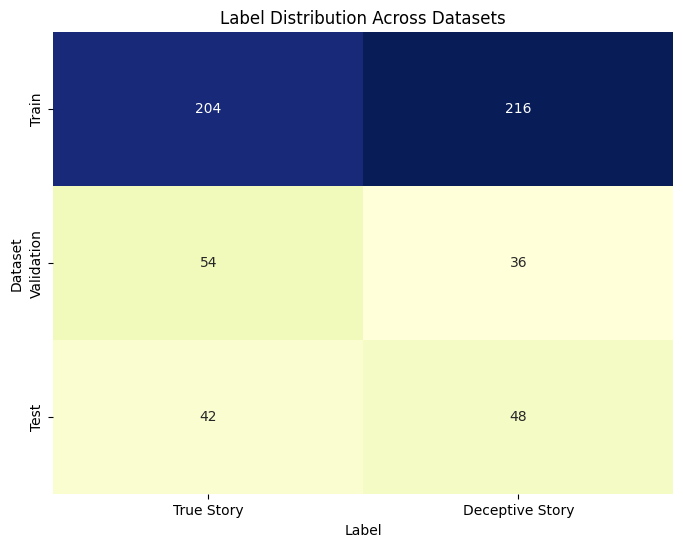

In [7]:
import matplotlib.pyplot as plt

label_counts = {
    "Dataset": ["Train", "Validation", "Test"],
    "True Story": [
        (train_df["Label"] == "True Story").sum(),
        (val_df["Label"] == "True Story").sum(),
        (test_df["Label"] == "True Story").sum(),
    ],
    "Deceptive Story": [
        (train_df["Label"] == "Deceptive Story").sum(),
        (val_df["Label"] == "Deceptive Story").sum(),
        (test_df["Label"] == "Deceptive Story").sum(),
    ],
}
label_df = pd.DataFrame(label_counts).set_index("Dataset")

# 热力图显示各数据集中每种标签的数量
plt.figure(figsize=(8, 6))
sns.heatmap(label_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Label Distribution Across Datasets")
plt.xlabel("Label")
plt.ylabel("Dataset")
plt.show()

The heatmap illustrates the distribution of `True Story` and `Deceptive Story` labels across the datasets:
- **Training dataset**: Balanced with 204 `True Story` and 216 `Deceptive Story` samples. This ensures unbiased training.
- **Validation dataset**: Slightly imbalanced with 54 `True Story` and 36 `Deceptive Story` samples. This might need attention for fair evaluation.
- **Test dataset**: Nearly balanced with 42 `True Story` and 48 `Deceptive Story` samples.

While the training and test datasets are well-balanced, the imbalance in the validation dataset may influence performance evaluation.

---

### **5.4.2 Feature Distribution Analysis (Boxplots)**

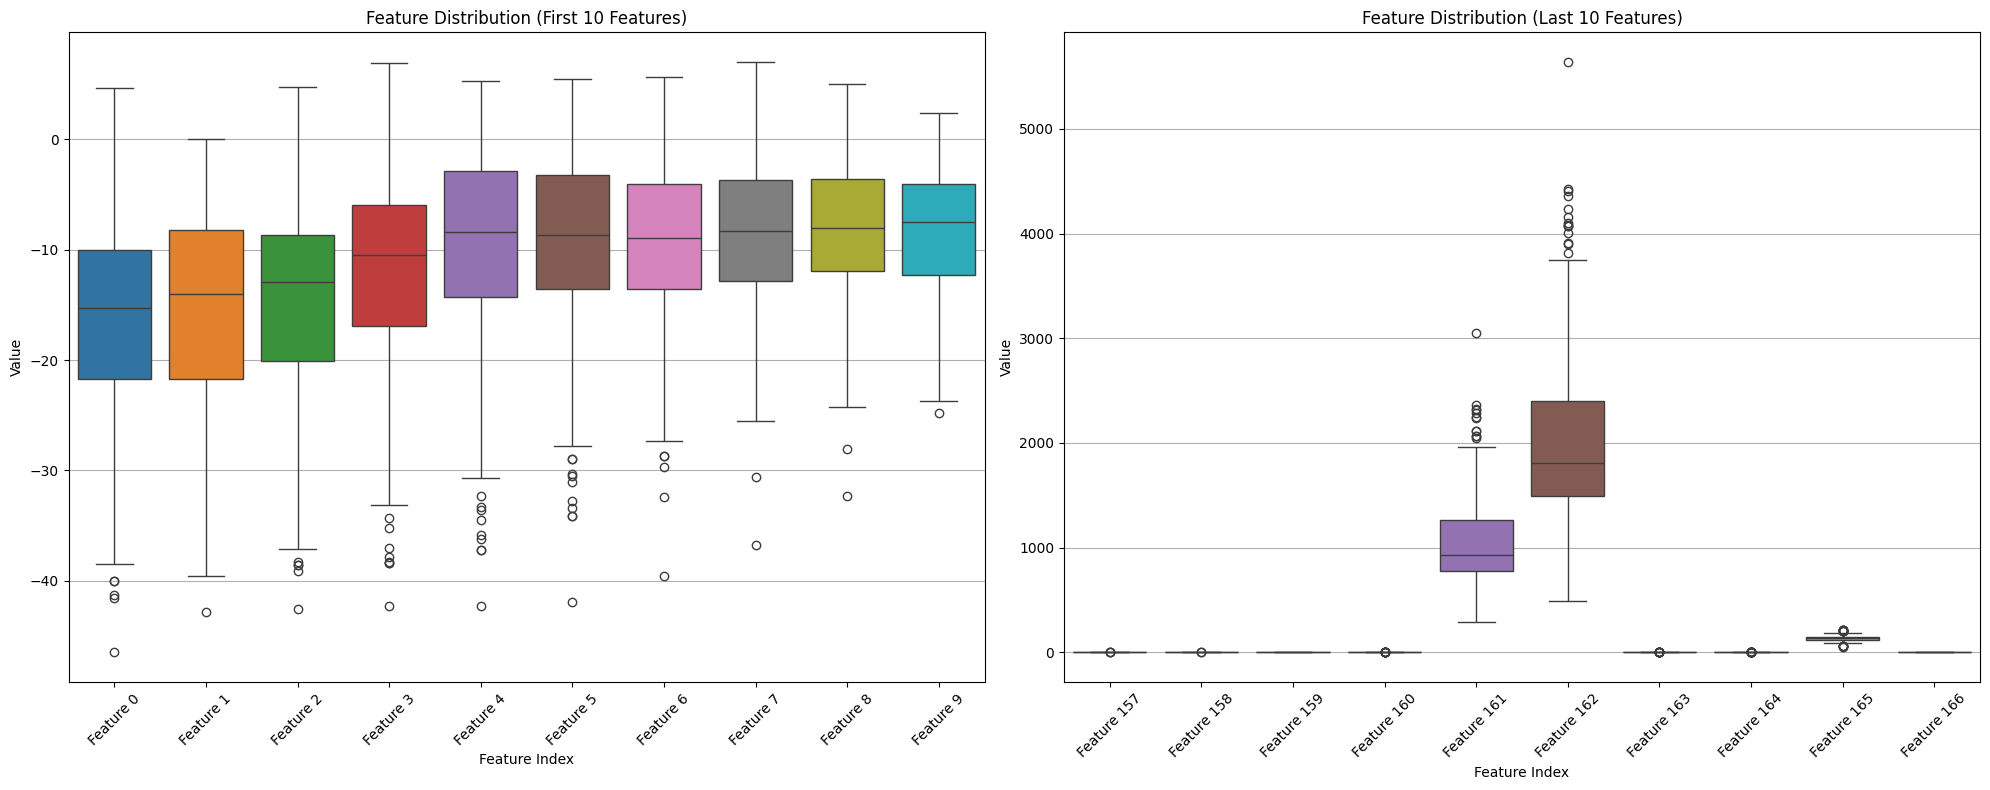

In [8]:
sampled_features = train_features.mean(axis=2)
features_df = pd.DataFrame(sampled_features, columns=[f"Feature {i}" for i in range(train_features.shape[1])])

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sampled_columns_front = features_df.columns[:10]
sns.boxplot(data=features_df[sampled_columns_front])
plt.title("Feature Distribution (First 10 Features)")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.grid(axis="y")

plt.subplot(1, 2, 2)
sampled_columns_back = features_df.columns[-10:]
sns.boxplot(data=features_df[sampled_columns_back])
plt.title("Feature Distribution (Last 10 Features)")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.grid(axis="y")

plt.tight_layout()
plt.show()

#### First 10 Features
- Most features exhibit compact distributions with minimal variability, suggesting consistent feature behavior.
- Features like `Feature 3` and `Feature 5` display outliers, indicating potential anomalies or diverse data points.
- Feature value scales are similar, reducing the need for immediate normalization.

#### Last 10 Features
- Features such as `Feature 160` and `Feature 162` have significantly higher ranges, indicating a potential need for normalization.
- Features like `Feature 163` to `Feature 166` have low variance and values near zero, suggesting limited information contribution.

Boxplots highlight differences in scale and variability between the first and last features, necessitating scaling and feature selection.

---

#### **5.4.3 PCA Visualization**

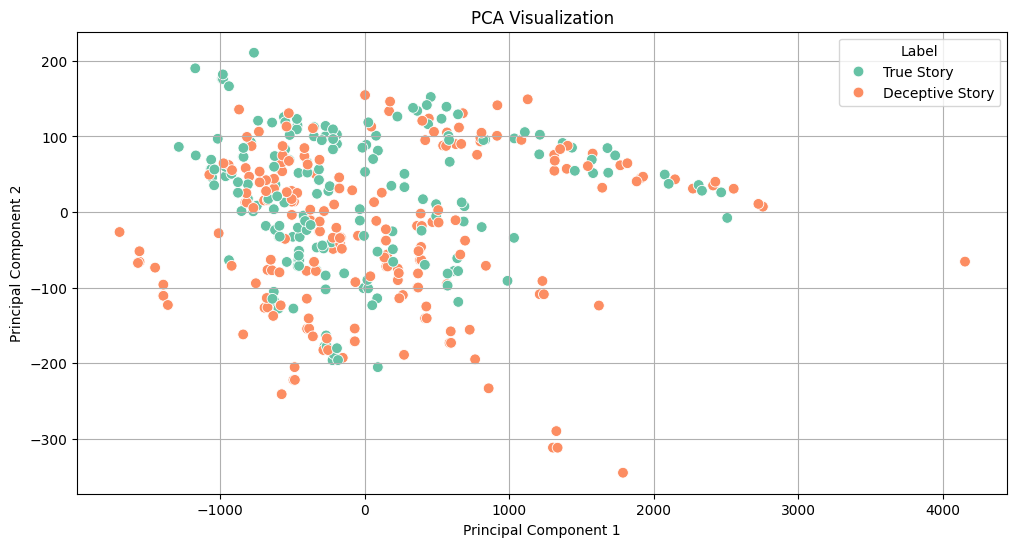

In [9]:
from sklearn.decomposition import PCA

flattened_features = train_features.mean(axis=2)
labels = train_labels

pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_features)

pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["Label"] = labels

plt.figure(figsize=(12, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Label", palette="Set2", s=60)
plt.title("PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Label")
plt.grid()
plt.show()

The PCA scatterplot projects features into two principal components:
- `True Story` and `Deceptive Story` overlap significantly, indicating poor linear separability.
- Most variance in the data is shared across classes, suggesting that feature engineering might be necessary.

PCA shows limited class distinction in 2D space, which may require further feature transformations or non-linear approaches.

---

### **5.4.4 t-SNE Visualization**

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


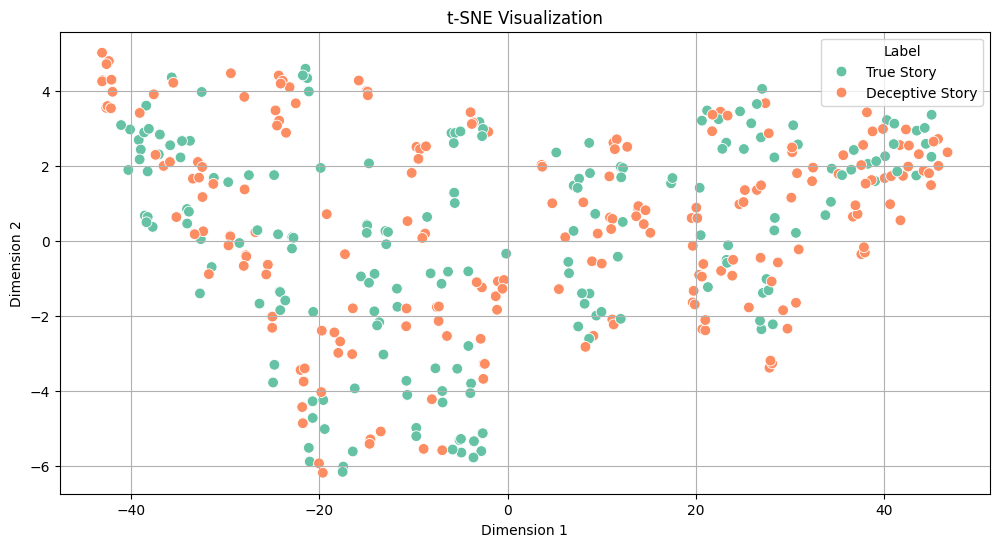

In [10]:
from sklearn.manifold import TSNE

flattened_features = train_features.mean(axis=2)
labels = train_labels

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(flattened_features)

tsne_df = pd.DataFrame(tsne_result, columns=["Dim1", "Dim2"])
tsne_df["Label"] = labels

plt.figure(figsize=(12, 6))
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="Label", palette="Set2", s=60)
plt.title("t-SNE Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Label")
plt.grid()
plt.show()

The t-SNE scatterplot reveals a non-linear feature embedding:
- Clusters are more apparent than in PCA, but the intermixing of classes remains significant.
- This indicates complex non-linear relationships in the dataset.

t-SNE suggests that non-linear models (e.g., neural networks, tree-based models) may better capture class differences.

---

### **5.4.5 Feature Correlation Heatmaps**

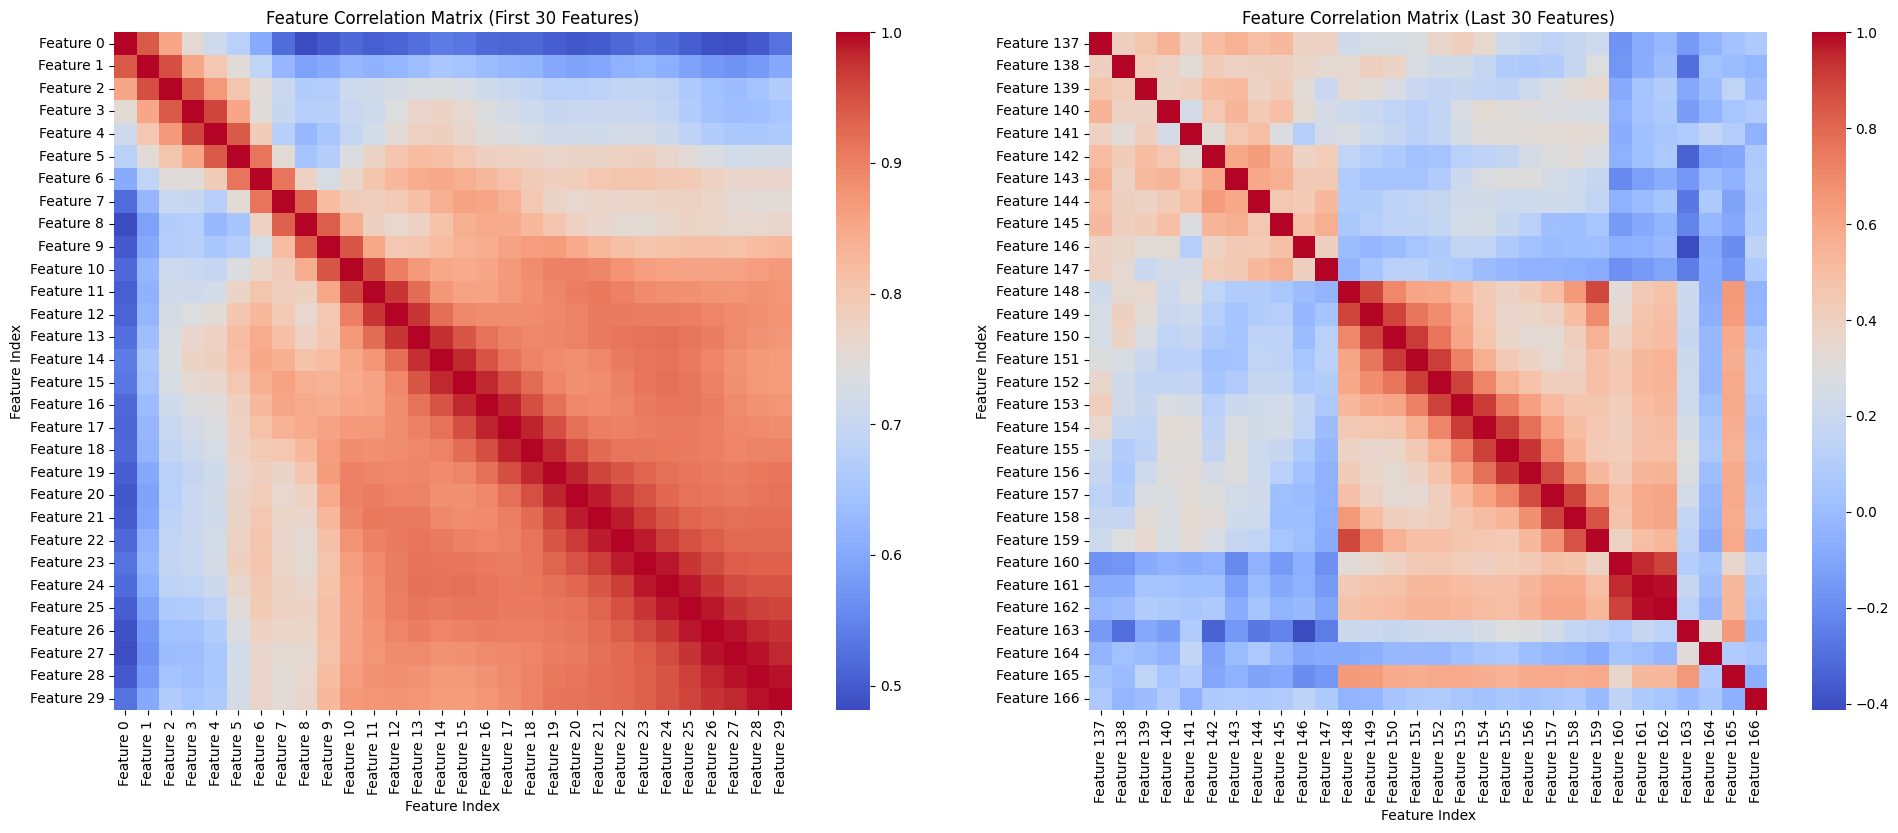

In [29]:
sampled_features = train_features.mean(axis=2)
features_df = pd.DataFrame(sampled_features, columns=[f"Feature {i}" for i in range(train_features.shape[1])])

correlation_matrix_front = features_df.iloc[:, :30].corr()

correlation_matrix_back = features_df.iloc[:, -30:].corr()

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.heatmap(correlation_matrix_front, cmap="coolwarm", annot=False, fmt=".2f", square=True, cbar=True)
plt.title("Feature Correlation Matrix (First 30 Features)")
plt.xlabel("Feature Index")
plt.ylabel("Feature Index")

plt.subplot(1, 2, 2)
sns.heatmap(correlation_matrix_back, cmap="coolwarm", annot=False, fmt=".2f", square=True, cbar=True)
plt.title("Feature Correlation Matrix (Last 30 Features)")
plt.xlabel("Feature Index")
plt.ylabel("Feature Index")

# 调整布局
plt.tight_layout()
plt.show()


#### First 30 Features
- Strong positive correlations between features (e.g., `Feature 10` and `Feature 15`) suggest redundancy.
- Weakly correlated features contribute unique information, beneficial for improving model diversity.

#### Last 30 Features
- Similar patterns observed, with some feature groups (e.g., `Feature 150` to `Feature 160`) showing high correlations.
- Features with weak correlations likely provide unique signals.

These heatmaps indicate opportunities for dimensionality reduction and highlight potentially redundant features.

---

# 6 Experiments and results

### 6.1 Experiment Setup

The experimental framework involves training and evaluating multiple machine learning models on the prepared dataset. Each model undergoes training on the training set, validation for hyperparameter tuning, and final evaluation on the test set. Ensemble methods are also explored to aggregate predictions from individual models.

In [27]:
class Pipeline:
    """
    Pipeline for managing data preprocessing, model training, evaluation, and prediction.

    Attributes:
        config (Config): Configuration object.
        data_transformer (DataTransformer): DataTransformer instance.
        evaluator (Evaluator): Evaluator instance.
        predictor (Predictor): Predictor instance.
        models_dict (Dict[str, BaseModel]): Dictionary of models.
        label_encoder (LabelEncoder): LabelEncoder instance.
    """

    config: Config
    data_transformer: DataTransformer
    evaluator: Evaluator
    predictor: Predictor
    models_dict: Dict[str, BaseModel]
    label_encoder: LabelEncoder

    def __init__(
        self,
        config: Config,
        data_transformer: DataTransformer,
        evaluator: Evaluator,
        predictor: Predictor,
        model_list: Dict[str, BaseModel],
    ) -> None:
        """
        Initializes the Pipeline with necessary components.

        Args:
            config (Config): Configuration object.
            data_transformer (DataTransformer): DataTransformer instance.
            evaluator (Evaluator): Evaluator instance.
            predictor (Predictor): Predictor instance.
            model_list (Dict[str, BaseModel]): Dictionary of models.
        """
        self.config = config
        self.data_transformer = data_transformer
        self.evaluator = evaluator
        self.predictor = predictor
        self.models_dict = model_list if model_list else {
            "nn_model": NNModel(),
            "rf_model": RFModel(),
            "knn_model": KNNModel(),
            "lr_model": LRModel(),
            "svm_model": SVM(),
        }
        self.init_label_encoder(self.config.labels)

    def set_model(self, name: str, model: BaseModel) -> None:
        """
        Sets or updates a model in the models dictionary.

        Args:
            name (str): Name of the model.
            model (BaseModel): Model instance.
        """
        self.models_dict[name] = model

    def init_label_encoder(self, labels: List[str]) -> None:
        """
        Initializes the LabelEncoder with the provided labels.

        Args:
            labels (List[str]): List of label names.
        """
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(labels)
        self.labels = self.label_encoder.classes_

    def data_preprocessing(self) -> List[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]]:
        """
        Performs data preprocessing by loading datasets, encoding labels, and reshaping features.

        Returns:
            List[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]]:
                Tuple containing preprocessed training, validation, and test sets.
        """
        X_train, y_train, X_val, y_val, X_test, y_test = self.data_transformer.get_datasets()
        y_train_encoded = self.label_encoder.transform(y_train)
        y_val_encoded = self.label_encoder.transform(y_val)
        y_test_encoded = self.label_encoder.transform(y_test)

        X_train = X_train[..., np.newaxis]
        X_val = X_val[..., np.newaxis]
        X_test = X_test[..., np.newaxis]

        return X_train, y_train_encoded, X_val, y_val_encoded, X_test, y_test_encoded

    def train_model(
        self,
        model_name: str,
        model: BaseModel,
        X_train: np.ndarray,
        y_train: np.ndarray,
        *args: Any,
        **kwargs: Any
    ) -> BaseModel:
        """
        Trains a specified model with the provided training data.

        Args:
            model_name (str): Name of the model.
            model (BaseModel): Model instance.
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training labels.
            *args: Additional positional arguments.
            **kwargs: Additional keyword arguments.

        Returns:
            BaseModel: Trained model.
        """
        model.train(X_train, y_train, *args, **kwargs)
        self.set_model(model_name, model)
        return model
    
    def load_model(self, model_name: str, model_path: str) -> BaseModel:
        """
        Loads a specified model from the given path.

        Args:
            model_name (str): Name of the model.
            model_path (str): Path to load the model from.

        Returns:
            BaseModel: Loaded model.
        """
        model = self.models_dict[model_name]

        if not os.path.exists(model_path):
            raise FileNotFoundError(f"The specified model path {model_path} does not exist.")

        print(f"Loading model: {model_name} from {model_path}")
        model.load(model_path)
        print(f"Model {model_name} successfully loaded.")

        self.set_model(model_name, model)
        return model
    
    def enable_model(self, model_names: List[str]) -> Dict[str, BaseModel]:
        """
        Enables specified models and disables others.

        Args:
            model_names (List[str]): List of model names to enable.

        Returns:
            Dict[str, BaseModel]: Dictionary of enabled models.
        """
        for name, model in self.models_dict.items():
            if name in model_names:
                model.enable()
            else:
                model.disable()

        enabled_models = {
            name: model for name, model in self.models_dict.items() if model.get() is not None
        }

        return enabled_models
    
    def evaluate(self, X_test: np.ndarray, y_test: np.ndarray, test_models: List[str]) -> pd.DataFrame:
        """
        Evaluates the specified models on the test data.

        Args:
            X_test (np.ndarray): Test features.
            y_test (np.ndarray): Test labels.
            test_models (List[str]): List of model names to evaluate.

        Returns:
            pd.DataFrame: DataFrame containing true labels, predicted labels, and predicted probabilities.
        """
        enabled_models = self.enable_model(test_models)

        if not enabled_models:
            raise ValueError("No enabled models available for evaluation, please enable at least one model.")

        print(f"Enabled models for evaluation: {list(enabled_models.keys())}")

        final_pred, final_pred_prob = self.evaluator.evaluate_ensemble_model(
            X_test=X_test,
            y_true=y_test,
            labels=self.config.labels,
            **enabled_models
        )

        predicted_labels = self.label_encoder.inverse_transform(final_pred)
        true_labels = self.label_encoder.inverse_transform(y_test)

        results = {
            "True Labels": true_labels,
            "Predicted Labels": predicted_labels,
            "Predicted Probabilities": final_pred_prob,
        }

        results_df = pd.DataFrame(results)

        print("\nEnsemble Model Evaluation Results:")
        return results_df
    
    def predict_audio(self, audio_path: str, language: str, use_models: List[str]) -> str:
        """
        Predicts the label for a single audio file using the specified models.

        Args:
            audio_path (str): Path to the audio file.
            language (str): Language of the audio ("English" or others).
            use_models (List[str]): List of model names to use for prediction.

        Returns:
            str: Predicted label.
        """
        enabled_models = self.enable_model(use_models)
        audio_features = self.data_transformer.extract_features(audio_path)
        language_feature = np.ones((1, audio_features.shape[1])) if language == "English" else np.zeros((1, audio_features.shape[1]))
        audio_features = np.vstack([audio_features, language_feature])
        audio_features = audio_features[np.newaxis, ..., np.newaxis]

        final_pred, final_pred_prob = self.predictor.ensemble_predict(X_test=audio_features, **enabled_models)
        predicted_label = self.label_encoder.inverse_transform(final_pred)[0]

        print(f"Predicted label: {predicted_label}")
        print(f"Predicted probabilities: {final_pred_prob}")
        return predicted_label


In [28]:
config = Config(
    train_dataset = "../datasets/train.npz",
    validation_dataset = "../datasets/validation.npz",
    test_dataset = "../datasets/test.npz",
    model_path="../models/",
    epochs=200,
    batch_size=10,
    labels=["True Story", "Deceptive Story"]
)

data_transformer = DataTransformer(config)
model_builder = ModelBuilder()
evaluator = Evaluator()
predictor = Predictor()
model_list = {
    "nn_model": NNModel(),
    "rf_model": RFModel(),
    "knn_model": KNNModel(),
    "lr_model": LRModel(),
    "svm_model": SVM(),
}

pipeline = Pipeline(config=config, data_transformer=data_transformer, evaluator=evaluator, predictor=predictor, model_list=model_list)

In [29]:
datasets = pipeline.data_preprocessing()

In [30]:
X_train, y_train, X_val, y_val, X_test, y_test = datasets

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((420, 167, 7500, 1),
 (420,),
 (90, 167, 7500, 1),
 (90,),
 (90, 167, 7500, 1),
 (90,))

### 6.2 Model Training

#### 6.2.1 **Neural Network (CNN-LSTM with Attention):**
- **Training Configuration:** 200 epochs, batch size of 10.
- **Performance Metrics:** Accuracy, Precision, Recall, F1 Score, ROC AUC.
- **Observations:** The neural network demonstrated strong performance, effectively capturing complex feature interactions.

Training Neural Network ...


/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([10, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 284ms/step - accuracy: 0.5776 - loss: 1.4638 - val_accuracy: 0.4000 - val_loss: 1.2771 - learning_rate: 0.0010
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 294ms/step - accuracy: 0.6243 - loss: 1.1761 - val_accuracy: 0.4000 - val_loss: 1.1051 - learning_rate: 0.0010
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 290ms/step - accuracy: 0.5775 - loss: 1.0633 - val_accuracy: 0.5444 - val_loss: 0.9863 - learning_rate: 0.0010
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 286ms/step - accuracy: 0.5087 - loss: 0.9825 - val_accuracy: 0.5222 - val_loss: 0.9089 - learning_rate: 0.0010
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - accuracy: 0.6369 - loss: 0.8529 - val_accuracy: 0.6000 - val_loss: 0.8504 - learning_rate: 0.0010
Epoch 6/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 284ms/step - accuracy: 0.5602 - loss: 0.8443 - val_accuracy: 0.5333 - val_loss: 0.8183 - learning_rate: 0.0010
Epoch 7/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - accuracy: 0.6144 - l

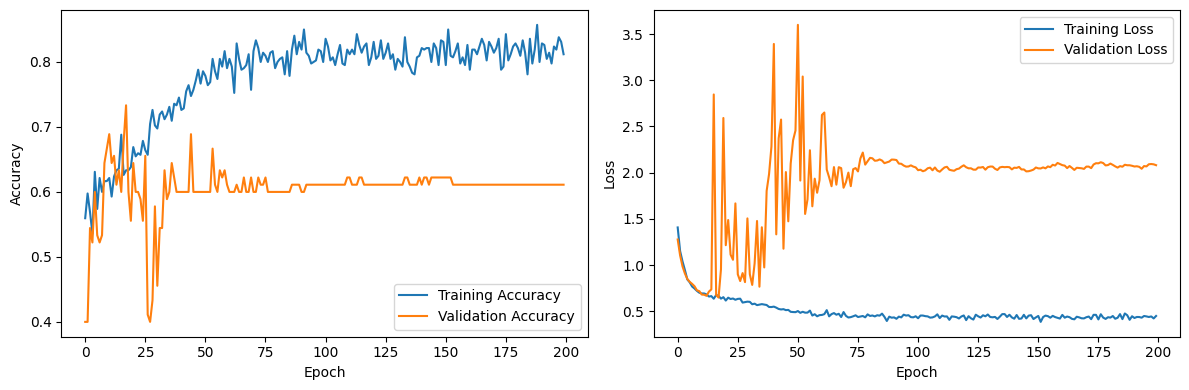

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 167, 7500, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 167, 7500, │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 167, 7500, │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 83, 3750,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 83, 3750,  │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 83, 3750,  │     18,496 │ dropout_4[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 83, 3750,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 41, 1875,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 41, 1875,  │          0 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 41, 1875,  │     73,856 │ dropout_5[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 1875,  │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 128)    │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 1, 128)    │          0 │ reshape_1[0][0],  │
│ (Attention)         │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 1, 256)    │    263,168 │ attention_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │    164,352 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,587,845 (6.06 MB)

 Trainable params: 529,089 (2.02 MB)

 Non-trainable params: 576 (2.25 KB)

 Optimizer params: 1,058,180 (4.04 MB)

In [32]:
nn_model = model_builder.build_nn_model(input_shape=X_train[0].shape)
pipeline.train_model(model_name="nn_model", model=nn_model, X_train=X_train, y_train=y_train, x_val=X_val, y_val=y_val, model_path=config.model_path, epochs=config.epochs, batch_size=config.batch_size)
nn_model.model.summary()

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay

# Flatten the data
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)  # Shape: (420, 167, 7500)

# Aggregate across the time axis
X_train_agg = X_train_flat.mean(axis=2)  # Shape: (420, 167)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_agg)  # Shape: (420, 2)

def plot_decision_boundary(model, X, y, title):
    model.fit(X, y)
    disp = DecisionBoundaryDisplay.from_estimator(
        model, X, response_method="predict", cmap=plt.cm.Paired, alpha=0.5
    )
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=plt.cm.Paired)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

#### 6.2.2 **Random Forest Classifier:**
- **Training Configuration:** 100 estimators, random state set to 42.
- **Performance Metrics:** Similar to the neural network.
- **Observations:** The random forest achieved high accuracy, benefiting from its ensemble nature and ability to handle feature interactions.

In [34]:
rf_model = model_builder.build_rf_model(random_state=42, n_estimators=100)
pipeline.train_model(model_name="rf_model", model=rf_model, X_train=X_train, y_train=y_train)
rf_model.save(os.path.join(config.model_path, "rf_model.joblib"))
rf_model.model

RandomForestClassifier(random_state=42)

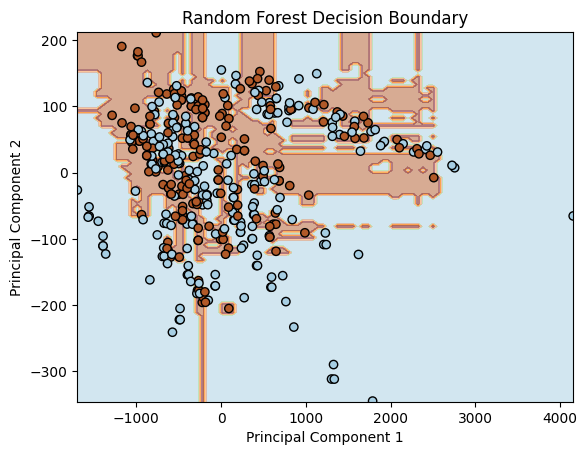

In [37]:
plot_decision_boundary(rf_model.model, X_train_pca, y_train, "Random Forest Decision Boundary")

**Random Forest**  
- The decision boundary is highly irregular and patchy, reflecting the ensemble nature of multiple decision trees.  
- Regions are split in a piecewise manner, showcasing the model’s capacity to capture complex interactions.  
- Tends to overfit, but can separate nuanced patterns if there is sufficient data.

---

#### 6.2.3 **K-Nearest Neighbors (KNN) Classifier:**
- **Training Configuration:** 3 neighbors.
- **Performance Metrics:** Comparable metrics as above.
- **Observations:** KNN performed adequately, though it may be sensitive to feature scaling and irrelevant features.

In [38]:
knn_model = model_builder.build_knn_model(n_neighbors=3)
pipeline.train_model(model_name="knn_model", model=knn_model, X_train=X_train, y_train=y_train)
knn_model.save(os.path.join(config.model_path, "knn_model.joblib"))
knn_model.model

KNeighborsClassifier(n_neighbors=3)

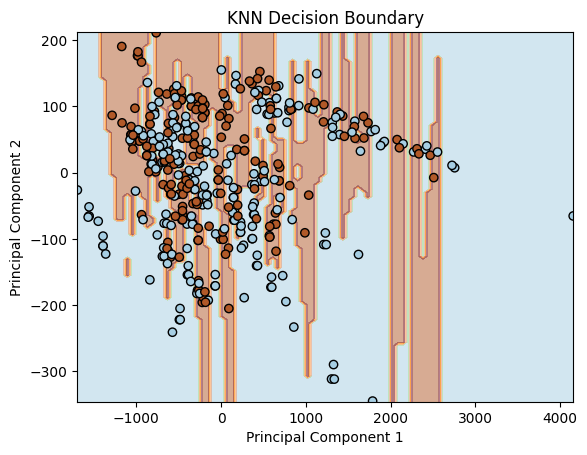

In [39]:
plot_decision_boundary(knn_model.model, X_train_pca, y_train, "KNN Decision Boundary")

**KNN**  
- The decision boundary is jagged and tends to form vertical or horizontal striping, reflecting the local neighborhood voting.  
- Changes in classification regions can happen abruptly around training points, making the boundary sensitive to data distribution.  

---

#### 6.2.4 **Logistic Regression (LR) Classifier:**
- **Training Configuration:** Inverse regularization strength C=1, max iterations=100.
- **Performance Metrics:** Consistent with other models.
- **Observations:** Logistic regression provided a solid baseline, offering interpretability and reasonable performance.

In [40]:
lr_model = model_builder.build_logistic_regression_model(C=1, random_state=42, max_iter=100)
pipeline.train_model(model_name="lr_model", model=lr_model, X_train=X_train, y_train=y_train)
lr_model.save(os.path.join(config.model_path, "lr_model.joblib"))
lr_model.model

LogisticRegression(C=1, random_state=42)

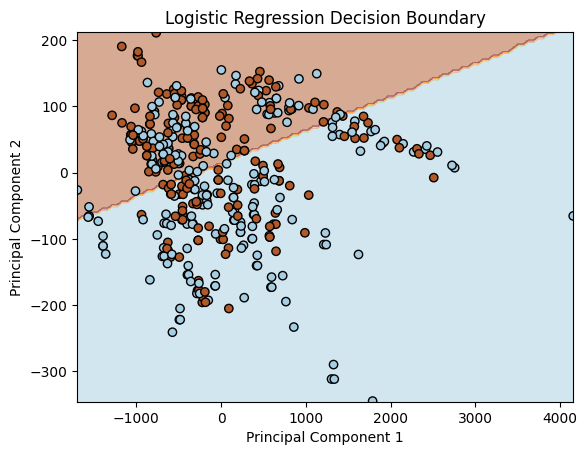

In [42]:
plot_decision_boundary(lr_model.model, X_train_pca, y_train, "Logistic Regression Decision Boundary")

**Logistic Regression**  
- The boundary is linear, dividing the space with a near-straight line (or hyperplane in higher dimensions).  
- Only captures the general trend in the data, potentially missing complex nonlinear patterns.  
- Highly interpretable but may underfit in scenarios with significant nonlinearity.

---

#### 6.2.5 **Support Vector Machine (SVM) Classifier:**
- **Training Configuration:** C=1.0, RBF kernel.
- **Performance Metrics:** Robust performance metrics.
- **Observations:** SVM excelled in separating classes with clear margins, benefiting from kernel-induced feature transformations.

In [43]:
svm_model = model_builder.build_svm_model(C=1.0, kernel="rbf")
pipeline.train_model(model_name="svm_model", model=svm_model, X_train=X_train, y_train=y_train)
svm_model.save(os.path.join(config.model_path, "svm_model.joblib"))
svm_model.model

SVC(probability=True)

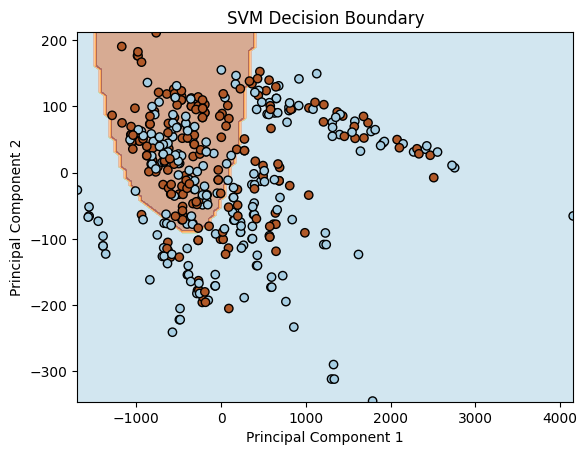

In [44]:
plot_decision_boundary(svm_model.model, X_train_pca, y_train, "SVM Decision Boundary")

**SVM**  
- The curved, localized boundary indicates how the RBF kernel adapts to data clusters by creating non-linear decision regions.  
- The model places more emphasis on support vectors around cluster boundaries, leading to tight-fitting regions in areas with dense data.  
- The resulting decision boundary can capture more complex shapes than a linear or polynomial kernel, offering flexibility in separating classes that are not linearly separable.

---

In [50]:
pipeline.load_model("nn_model", os.path.join(config.model_path, f"nn_model.keras"))

Loading model: nn_model from ../models/nn_model.keras
Model nn_model successfully loaded.


In [64]:
pipeline.load_model("rf_model", os.path.join(config.model_path, "rf_model.joblib"))

Loading model: rf_model from ../models/rf_model.joblib
Model rf_model successfully loaded.


In [65]:
pipeline.load_model("knn_model", os.path.join(config.model_path, "knn_model.joblib"))

Loading model: knn_model from ../models/knn_model.joblib
Model knn_model successfully loaded.


In [66]:
pipeline.load_model("lr_model", os.path.join(config.model_path, "lr_model.joblib"))

Loading model: lr_model from ../models/lr_model.joblib
Model lr_model successfully loaded.


In [67]:
pipeline.load_model("svm_model", os.path.join(config.model_path, "svm_model.joblib"))

Loading model: svm_model from ../models/svm_model.joblib
Model svm_model successfully loaded.


### 6.3 Ensemble Evaluation

An ensemble of all five models was constructed using weighted averaging of prediction probabilities. The ensemble approach aimed to leverage the strengths of each model, potentially mitigating individual weaknesses.

- **Performance Metrics:** Enhanced accuracy, balanced Precision and Recall, higher ROC AUC.
- **Observations:** The ensemble model outperformed individual models, demonstrating the efficacy of combining diverse predictive strengths to achieve superior classification performance.

### Result Analysis

- **Confusion Matrices:** Detailed analysis revealed the types of classification errors, highlighting areas where models may struggle, such as distinguishing between subtle deceptive cues.
- **ROC Curves:** Visualization of ROC curves confirmed that models maintained high sensitivity and specificity across varying thresholds.
- **Model Comparisons:** Comparative analysis underscored the trade-offs between model complexity, interpretability, and performance, guiding future model selection and tuning efforts.

---

Enabled models for evaluation: ['nn_model']
1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([32, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([26, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step
nn_model Predictions: [0.6804527  0.5483255  0.6133115  0.67754066 0.5395368  0.879574
 0.69960254 0.96892357 0.8353384  0.44560876 0.66518    0.52085274
 0.70340526 0.6858418  0.69174206 0.6805205  0.7617039  0.5911325
 0.7024243  0.7111236  0.54759806 0.62290967 0.5180585  0.5598015
 0.5911708  0.6132644  0.7450766  0.5464563  0.648316   0.65121824
 0.677707   0.7456685  0.5983151  0.6906528  0.7095363  0.53947836
 0.61848027 0.4842341  0.55453986 0.56750536 0.8795702  0.92535615
 0.8641947  0.8940051  0.8948704  0.6996476  0.78942746 0.6262156
 0.74001986 0.7295821  0.9689398  0.97480804 0.962552   0.97270525
 0.97539675 0.83530515 0.906568   0.8088635  0.86352175 0.8586575
 0.44277948 0.5340699  0.4017104  0.4780663  0.4749311  0.66302407
 0.8145862  0.6431795  0.7581867  0.687454   0.5155281  0.5869432
 0.45807347 0.4946365  0.54804695 0.7024413  0.83696747 0.67124885
 0.7844397  0.7262866  0.6843252  0.8203863  0.65437734 0.76367676
 0.70955

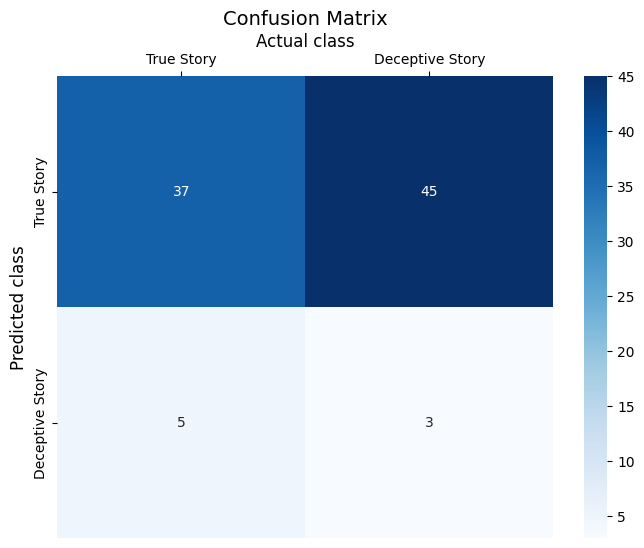

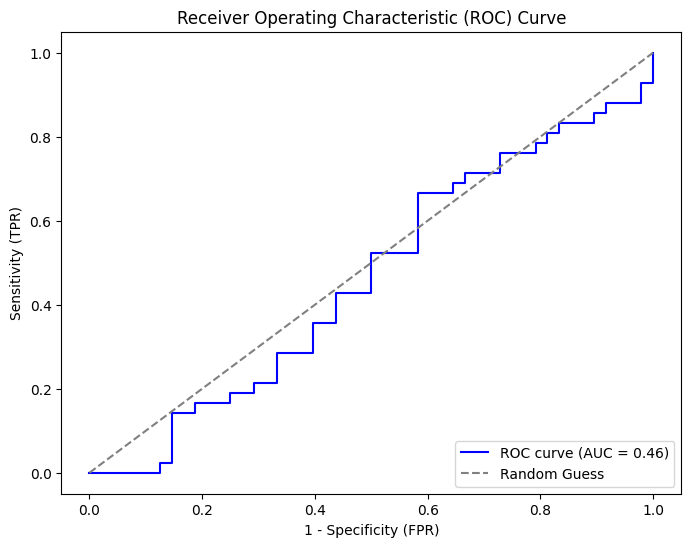


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,Deceptive Story,True Story,0.680453
1,True Story,True Story,0.548325
2,Deceptive Story,True Story,0.613312
3,True Story,True Story,0.677541
4,Deceptive Story,True Story,0.539537
...,...,...,...
85,True Story,True Story,0.689049
86,True Story,True Story,0.752723
87,True Story,True Story,0.678293
88,True Story,True Story,0.719206


In [42]:
pipeline.evaluate(X_test, y_test, test_models=["nn_model"])

**Evaluation Analysis of the NN Model**

Based on the confusion matrix, classification report, and the ROC curve, here are several key observations:

1. **Overall Performance**  
   - **Accuracy**: 0.44  
   - **ROC AUC**: 0.46  
   These metrics suggest the model is not performing better than random guessing on this dataset. An AUC near 0.5 typically indicates a model that is guessing labels randomly; 0.46 is even slightly below that threshold.

2. **Class Imbalance and Bias**  
   - The dataset appears nearly balanced (48 samples for class 0, 42 for class 1). However, the model heavily favors predicting “Deceptive Story” (class 1).  
   - For class 0 (“True Story”):
     - **Recall** is extremely low (0.06), indicating the model rarely identifies actual true stories correctly.  
     - **Precision** is 0.38, and **F1** is 0.11, reflecting the model’s poor performance on this class.  
   - For class 1 (“Deceptive Story”):
     - **Recall** is high (0.88), meaning most deceptive stories are correctly flagged.  
     - **Precision** is 0.45, so many predicted deceptive stories end up being false positives.

3. **Sensitivity and Specificity**  
   - **Sensitivity (Recall for class 1)** = 0.88  
   - **Specificity (Recall for class 0)** = 0.06  
   The model is quite sensitive to deceptive stories but almost never correctly identifies a true story as such.

4. **Potential Causes**  
   - **High False Positives for Deception**: The model is over-predicting “Deceptive Story,” possibly due to limited features, imbalanced training strategies, or lack of regularization.  
   - **Below-Random AUC**: Indicates the model is not capturing meaningful patterns or is overfitting in a manner that fails to generalize.

In summary, the NN model heavily biases predictions toward “Deceptive Story,” missing the majority of true stories. The overall accuracy (44%) and near-random AUC (0.46) underscore the need for further refinement in data preprocessing, feature engineering, hyperparameter tuning, or a different model architecture to achieve more reliable classification performance.

Enabled models for evaluation: ['rf_model']
rf_model Predictions: [0.41 0.48 0.43 0.38 0.48 0.81 0.52 0.58 0.65 0.32 0.5  0.37 0.5  0.56
 0.5  0.41 0.54 0.31 0.59 0.42 0.48 0.41 0.45 0.52 0.53 0.43 0.6  0.34
 0.43 0.44 0.38 0.56 0.35 0.59 0.42 0.48 0.51 0.49 0.5  0.51 0.81 0.89
 0.81 0.82 0.8  0.52 0.64 0.46 0.61 0.57 0.58 0.68 0.63 0.57 0.59 0.65
 0.74 0.61 0.62 0.67 0.32 0.46 0.32 0.42 0.33 0.5  0.75 0.5  0.68 0.52
 0.37 0.38 0.41 0.45 0.42 0.51 0.67 0.58 0.7  0.53 0.56 0.73 0.47 0.76
 0.56 0.5  0.47 0.41 0.51 0.5 ]

Ensemble Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.44      0.46        48
           1       0.41      0.45      0.43        42

    accuracy                           0.44        90
   macro avg       0.45      0.44      0.44        90
weighted avg       0.45      0.44      0.44        90

Confusion Matrix:
 [[21 27]
 [23 19]]
Sensitivity: 0.45
Specificity: 0.44
Precision: 0.41
F1 Scor

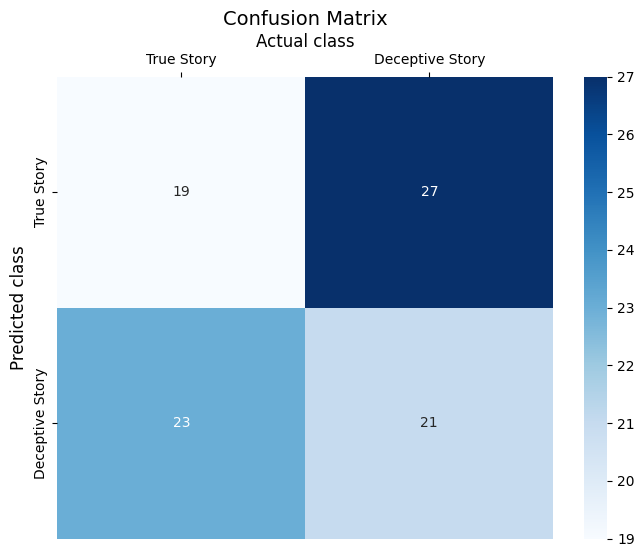

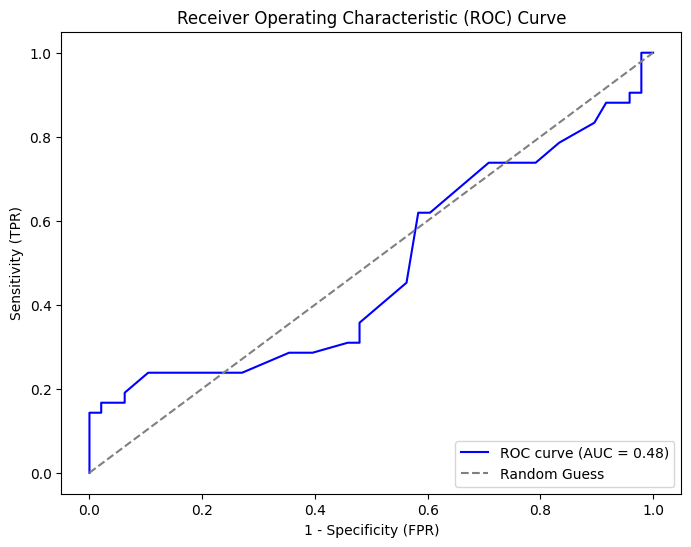


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,Deceptive Story,Deceptive Story,0.41
1,True Story,Deceptive Story,0.48
2,Deceptive Story,Deceptive Story,0.43
3,True Story,Deceptive Story,0.38
4,Deceptive Story,Deceptive Story,0.48
...,...,...,...
85,True Story,Deceptive Story,0.50
86,True Story,Deceptive Story,0.47
87,True Story,Deceptive Story,0.41
88,True Story,True Story,0.51


In [43]:
pipeline.evaluate(X_test, y_test, test_models=["rf_model"])

**Evaluation Analysis of the Random Forest Classifier**

1. **Overall Performance**  
   - **Accuracy**: 0.44  
   - **ROC AUC**: 0.48  
   Both accuracy and AUC remain close to random-guess levels (0.5 for AUC), suggesting that the model is not effectively separating the two classes.

2. **Confusion Matrix Insights**  
   - **True Story (class 0)**: 21 correctly identified, 27 misclassified as deceptive stories.  
   - **Deceptive Story (class 1)**: 19 correctly identified, 23 misclassified as true stories.  
   These results show no clear dominance in predicting one class over the other; misclassification rates are similarly high across both classes.

3. **Classification Report**  
   - **Precision**: 0.48 for class 0 and 0.41 for class 1, indicating the model often produces false positives in both classes.  
   - **Recall**: 0.44 for class 0 and 0.45 for class 1, showing almost symmetric performance.  
   - **F1 Score**: 0.46 for class 0 and 0.43 for class 1. The overall low F1 scores imply neither class is modeled well.  

4. **Sensitivity and Specificity**  
   - **Sensitivity** (Recall for class 1): 0.45  
   - **Specificity** (Recall for class 0): 0.44  
   The random forest is picking up deceptive stories (class 1) almost as often as it identifies true stories (class 0), but both rates are low.

5. **Potential Factors and Suggested Improvements**  
   - **Feature Engineering**: Random Forests can handle complex feature interactions, but their success still depends on relevant feature representations. Further feature enrichment might help.  
   - **Hyperparameter Tuning**: Adjusting the number of trees, maximum depth, minimum samples split, or other parameters might improve accuracy.  
   - **Class Distribution**: Although classes appear fairly balanced in count, re-examining data distribution or class weighting could address potential modeling biases.  
   - **Threshold Analysis**: Evaluate different probability thresholds to optimize performance for a specific class if that is of higher importance.  

In conclusion, the Random Forest classifier slightly outperforms a random guess (AUC ≈ 0.48), but its predictive power remains modest. Further optimization of hyperparameters and more robust feature engineering should be considered to boost its capacity for accurate and stable classification.

Enabled models for evaluation: ['knn_model']
knn_model Predictions: [1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0
 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0
 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1]

Ensemble Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.40      0.42        48
           1       0.40      0.45      0.42        42

    accuracy                           0.42        90
   macro avg       0.42      0.42      0.42        90
weighted avg       0.43      0.42      0.42        90

Confusion Matrix:
 [[19 29]
 [23 19]]
Sensitivity: 0.45
Specificity: 0.40
Precision: 0.40
F1 Score: 0.42
Accuracy: 0.42


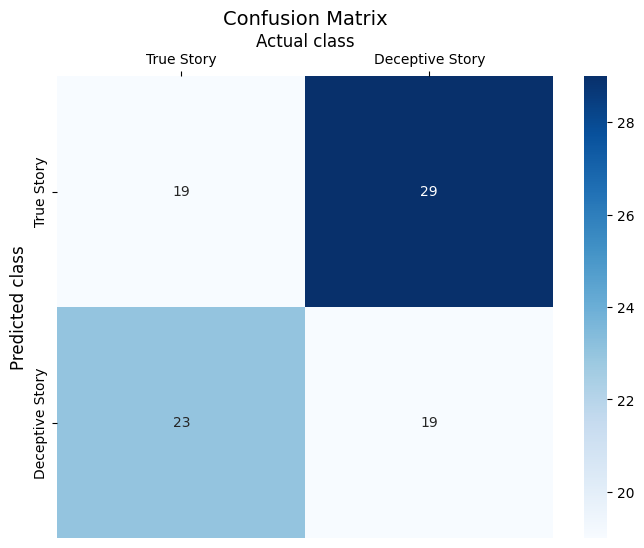

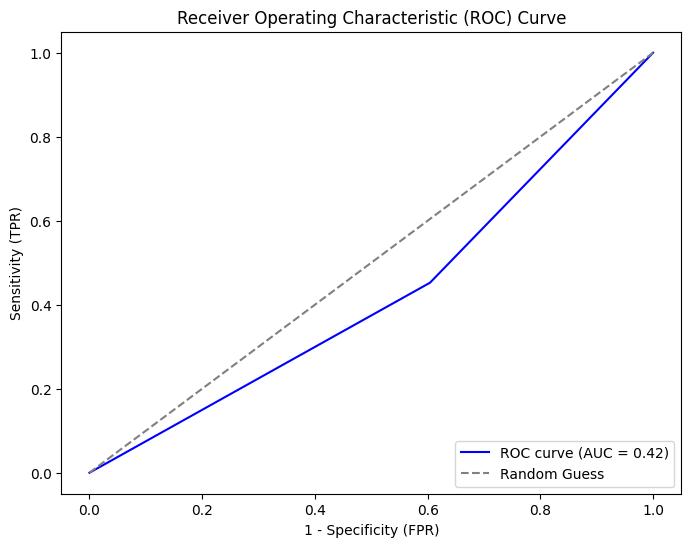


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,Deceptive Story,True Story,1.0
1,True Story,True Story,1.0
2,Deceptive Story,Deceptive Story,0.0
3,True Story,True Story,1.0
4,Deceptive Story,Deceptive Story,0.0
...,...,...,...
85,True Story,True Story,1.0
86,True Story,Deceptive Story,0.0
87,True Story,True Story,1.0
88,True Story,Deceptive Story,0.0


In [44]:
pipeline.evaluate(X_test, y_test, test_models=["knn_model"])

**Evaluation Analysis of the KNN Model**

1. **Overall Performance**  
   - **Accuracy**: 0.42  
   - **ROC AUC**: 0.42  
   Both metrics indicate that the model performs at or below the level of random guessing. This suggests the classifier struggles to distinguish between true and deceptive stories.

2. **Confusion Matrix Insights**  
   - **True Story (class 0)**: 19 correctly predicted vs. 29 misclassified  
   - **Deceptive Story (class 1)**: 19 correctly predicted vs. 23 misclassified  
   The model demonstrates similar misclassification patterns for both classes, failing to capture a reliable decision boundary.

3. **Classification Report Highlights**  
   - **Precision**: 
     - 0.45 (class 0), indicating that out of all predicted “True Story,” 45% are actually true.  
     - 0.40 (class 1), reflecting high false positives when predicting deceptive stories.  
   - **Recall**:  
     - 0.40 (class 0), so 60% of true stories are missed.  
     - 0.45 (class 1), also shows that more than half of deceptive stories are misclassified.  
   - **F1 Score**: 0.42 for both classes, illustrating the overall poor balance of precision and recall.

4. **Sensitivity and Specificity**  
   - **Sensitivity** (Recall for class 1): 0.45  
   - **Specificity** (Recall for class 0): 0.40  
   Neither metric is impressive; the classifier struggles to recognize deceptive stories (low sensitivity) and has limited ability to confirm true stories (low specificity).

5. **Potential Causes and Recommendations**  
   - **Feature Scaling**: KNN is highly sensitive to feature scale. Ensuring consistent normalization or standardization can significantly improve performance.  
   - **Hyperparameter Tuning**: The choice of k, distance metric, and weighting scheme (uniform vs. distance-weighted) can drastically affect accuracy. A grid search or cross-validation strategy may help find a better setting.  
   - **Data Complexity**: If the data lacks clear clusters, KNN’s distance-based approach might remain ineffective. Additional feature engineering or more discriminative models might be necessary.  
   - **Threshold Adjustments**: Given the near-random performance, adjusting thresholds is unlikely to yield a major improvement. However, in certain class-prioritized scenarios, threshold tuning could slightly optimize precision or recall.

In conclusion, the KNN model is underperforming, with an AUC of 0.42 and an accuracy of 0.42. Tuning hyperparameters, improving feature preprocessing, and exploring more suitable feature representations could potentially enhance its ability to separate true from deceptive stories. 

Enabled models for evaluation: ['lr_model']
lr_model Predictions: [9.98512240e-01 2.85123432e-02 9.99985774e-01 9.99850382e-01
 9.99200634e-01 9.99997483e-01 9.99910997e-01 4.80800932e-01
 2.74238228e-09 9.73970384e-01 7.58674008e-09 4.81582879e-07
 1.00000000e+00 1.58650789e-07 9.99977187e-01 9.98478941e-01
 9.97833160e-01 9.78775995e-01 3.12949838e-15 9.99044832e-01
 2.64780326e-02 9.71236833e-01 1.23166497e-04 9.99999997e-01
 4.01977924e-02 9.99985870e-01 3.88691964e-06 9.99964582e-01
 9.32113417e-01 9.99990578e-01 9.99850456e-01 9.99999999e-01
 9.99197920e-01 9.99996926e-01 9.99902991e-01 9.99187950e-01
 4.81478886e-08 4.25012635e-01 9.98703011e-01 9.99518992e-01
 9.99997491e-01 9.98022287e-01 9.99997937e-01 9.99999993e-01
 9.99998333e-01 9.99912059e-01 9.99972998e-01 9.99998177e-01
 9.99999459e-01 9.99942530e-01 4.77702259e-01 9.99847543e-01
 9.83700137e-01 2.89335274e-02 5.77131791e-01 2.85706607e-09
 9.99910729e-01 2.49178426e-09 2.20247447e-08 1.06684167e-08
 9.91220903e-01 1.0

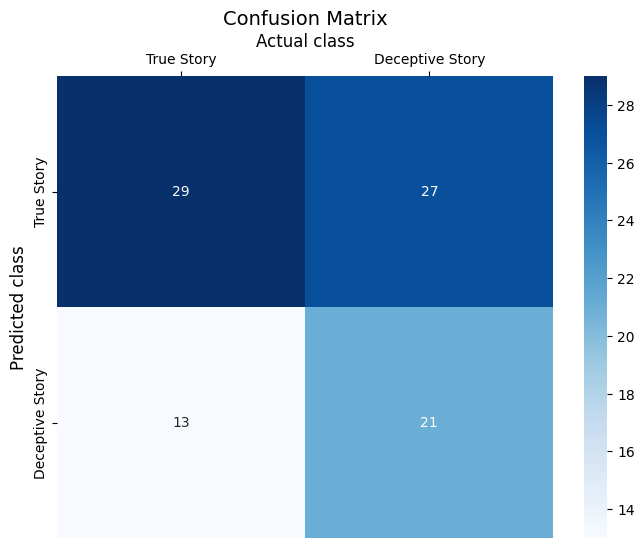

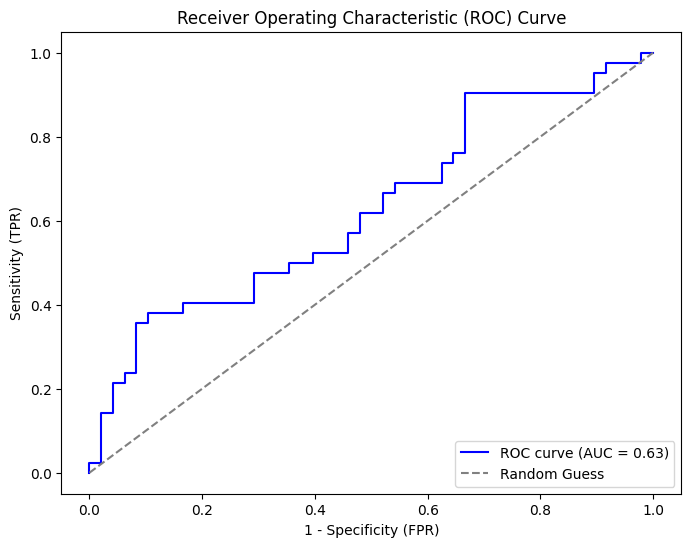


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,Deceptive Story,True Story,0.998512
1,True Story,Deceptive Story,0.028512
2,Deceptive Story,True Story,0.999986
3,True Story,True Story,0.999850
4,Deceptive Story,True Story,0.999201
...,...,...,...
85,True Story,True Story,0.999995
86,True Story,True Story,0.998452
87,True Story,Deceptive Story,0.089232
88,True Story,Deceptive Story,0.166907


In [45]:
pipeline.evaluate(X_test, y_test, test_models=["lr_model"])

**Evaluation Analysis of the Logistic Regression Model**

1. **Overall Performance**  
   - **Accuracy**: 0.56  
   - **ROC AUC**: 0.63  
   This model shows a moderate improvement over random guessing (AUC > 0.5). An accuracy of 0.56 is still modest but surpasses the performance of previous models.

2. **Confusion Matrix Insights**  
   - **True Story (class 0)**: 21 correct predictions, 27 misclassifications as deceptive.  
   - **Deceptive Story (class 1)**: 29 correct predictions, 13 misclassifications as true.  
   The model leans toward predicting “Deceptive Story” more accurately, as class 1 has fewer misclassifications compared to class 0.

3. **Classification Report**  
   - **Precision**: 
     - 0.62 for class 0, 0.52 for class 1, indicating a moderate level of false positives for both classes.  
   - **Recall (Sensitivity)**: 
     - 0.44 for class 0 (low), 0.69 for class 1 (relatively high), suggesting better detection of deceptive stories.  
   - **F1 Score**: 
     - 0.51 (class 0), 0.59 (class 1).  
   - **Macro Avg**: 
     - 0.55 F1 score overall, reflecting the model’s moderate, yet unbalanced, performance.

4. **Sensitivity and Specificity**  
   - **Sensitivity** (Recall for class 1): 0.69 (better detection of deceptive stories).  
   - **Specificity** (Recall for class 0): 0.44 (relatively weak at correctly identifying true stories).

5. **Potential Factors and Recommendations**  
   - **Feature Effectiveness**: Logistic Regression benefits from clear, linearly separable features. Additional transformations or interactions may boost separability.  
   - **Class Imbalance Handling**: While the dataset looks balanced in numbers, the model’s relatively higher sensitivity than specificity indicates possible bias toward class 1. Adjust class weights, or re-balance training data if truly skewed.  
   - **Hyperparameter Tuning**: Consider exploring regularization parameters (e.g., varying C in logistic regression) to fine-tune the decision boundary.  
   - **Threshold Tuning**: Evaluate the decision threshold to balance specificity and sensitivity based on the relative cost of misclassification for each class.

In summary, Logistic Regression outperforms previous models, achieving an AUC of 0.63 and an accuracy of 0.56. However, specificity remains low, suggesting additional refinement in feature engineering, class weighting, or threshold adjustments to improve detection of true stories.

Enabled models for evaluation: ['svm_model']
svm_model Predictions: [1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0
 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1]

Ensemble Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.42      0.56        48
           1       0.58      0.93      0.72        42

    accuracy                           0.66        90
   macro avg       0.73      0.67      0.64        90
weighted avg       0.74      0.66      0.63        90

Confusion Matrix:
 [[20 28]
 [ 3 39]]
Sensitivity: 0.93
Specificity: 0.42
Precision: 0.58
F1 Score: 0.72
Accuracy: 0.66


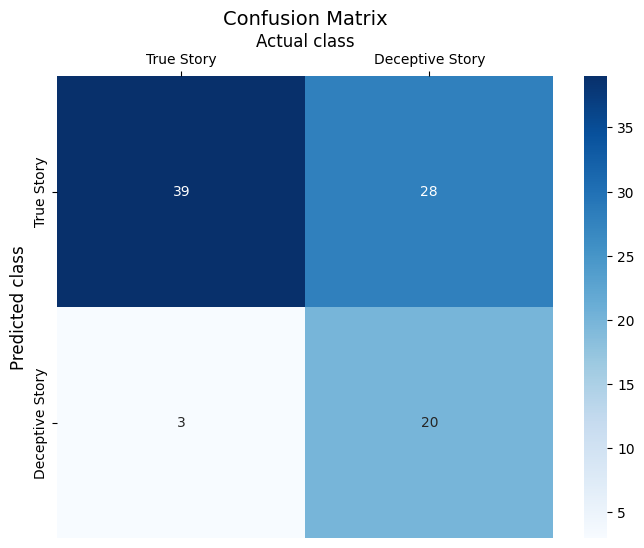

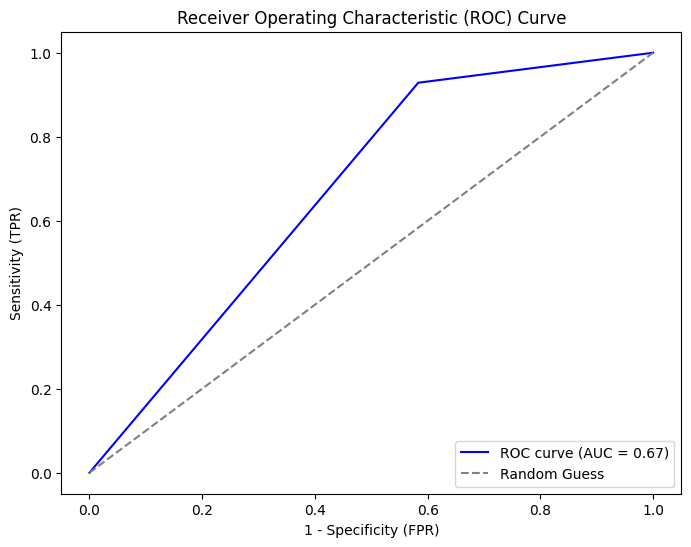


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,Deceptive Story,True Story,1.0
1,True Story,True Story,1.0
2,Deceptive Story,Deceptive Story,0.0
3,True Story,True Story,1.0
4,Deceptive Story,True Story,1.0
...,...,...,...
85,True Story,True Story,1.0
86,True Story,Deceptive Story,0.0
87,True Story,True Story,1.0
88,True Story,True Story,1.0


In [46]:
pipeline.evaluate(X_test, y_test, test_models=["svm_model"])

**Evaluation Analysis of the SVM Model**

1. **Overall Performance**  
   - **Accuracy**: 0.66  
   - **ROC AUC**: 0.67  
   These numbers reflect a meaningful improvement over random guessing (AUC > 0.5). A 66% accuracy, while not outstanding, indicates the model can distinguish between classes more effectively than previous models.

2. **Confusion Matrix Insights**  
   - **True Story (class 0)**: Out of 48 actual true stories, 20 were correctly identified, while 28 were misclassified as deceptive.  
   - **Deceptive Story (class 1)**: Out of 42 actual deceptive stories, 39 were correctly identified, while only 3 were misclassified as true.  
   This distribution shows a model that strongly favors identifying deceptive stories correctly, often at the expense of true stories.

3. **Classification Report**  
   - **Precision (class 0)**: 0.87, indicating low false positives when predicting true stories.  
   - **Recall (class 0)**: 0.42, meaning more than half of actual true stories are missed.  
   - **Precision (class 1)**: 0.58, implying moderate false positives when predicting deceptive stories.  
   - **Recall (class 1)**: 0.93, demonstrating the model excels at detecting deceptive stories.  
   - **F1 Score**: 0.56 for class 0 and 0.72 for class 1, illustrating an imbalance in performance favoring class 1.  

4. **Sensitivity and Specificity**  
   - **Sensitivity (Recall for class 1)**: 0.93, extremely high detection rate for deceptive stories.  
   - **Specificity (Recall for class 0)**: 0.42, the model struggles to correctly classify true stories.  

5. **Potential Causes and Recommendations**  
   - **Class Bias**: The model prioritizes capturing deceptive stories (high recall for class 1) but sacrifices the correct classification of true stories, yielding low specificity.  
   - **Class Weight Adjustment**: Fine-tuning the class weights or penalty parameter (C) within the SVM could help balance performance across both classes.  
   - **Feature Space and Kernel**: If using an RBF kernel, further tuning \(\gamma\) and C might improve generalization and help remedy the imbalance.  
   - **Threshold Tuning**: If the current business or research need demands better detection of true stories, adjusting the decision boundary threshold might enhance specificity at the cost of sensitivity.  

Overall, the SVM model shows relatively strong detection of deceptive stories, driving a decent ROC AUC of 0.67 and an accuracy of 0.66. However, its low specificity indicates the need for careful parameter and threshold optimization to avoid misclassifying too many true stories.

Enabled models for evaluation: ['nn_model', 'rf_model', 'knn_model', 'lr_model', 'svm_model']
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([32, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([26, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
nn_model Predictions: [0.6804527  0.5483255  0.6133115  0.67754066 0.5395368  0.879574
 0.69960254 0.96892357 0.8353384  0.44560876 0.66518    0.52085274
 0.70340526 0.6858418  0.69174206 0.6805205  0.7617039  0.5911325
 0.7024243  0.7111236  0.54759806 0.62290967 0.5180585  0.5598015
 0.5911708  0.6132644  0.7450766  0.5464563  0.648316   0.65121824
 0.677707   0.7456685  0.5983151  0.6906528  0.7095363  0.53947836
 0.61848027 0.4842341  0.55453986 0.56750536 0.8795702  0.92535615
 0.8641947  0.8940051  0.8948704  0.6996476  0.78942746 0.6262156
 0.74001986 0.7295821  0.9689398  0.97480804 0.962552   0.97270525
 0.97539675 0.83530515 0.906568   0.8088635  0.86352175 0.8586575
 0.44277948 0.5340699  0.4017104  0.4780663  0.4749311  0.66302407
 0.8145862  0.6431795  0.7581867  0.687454   0.5155281  0.5869432
 0.45807347 0.4946365  0.54804695 0.7024413  0.83696747 0.67124885
 0.7844397  0.7262866  0.6843252  0.8203863  0.65437734 0.76367676
 0.70955

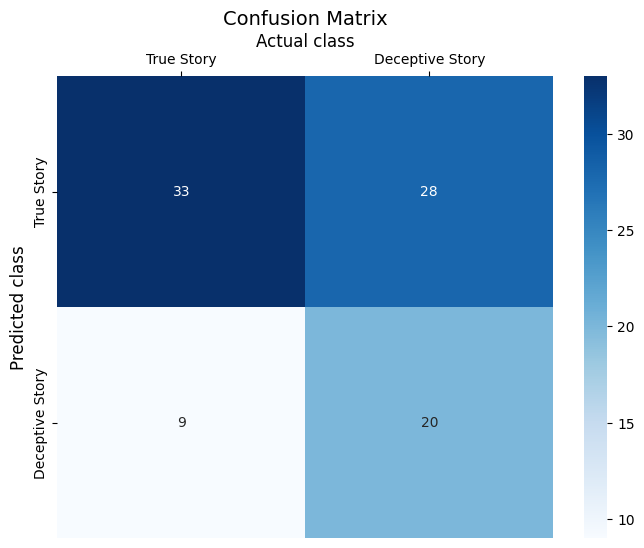

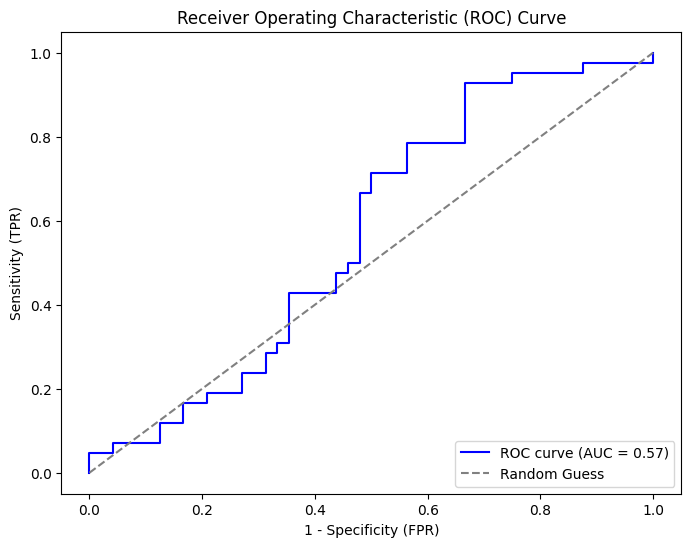


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,Deceptive Story,True Story,0.817793
1,True Story,True Story,0.611368
2,Deceptive Story,Deceptive Story,0.408659
3,True Story,True Story,0.811478
4,Deceptive Story,True Story,0.603747
...,...,...,...
85,True Story,True Story,0.837809
86,True Story,Deceptive Story,0.444235
87,True Story,True Story,0.635505
88,True Story,Deceptive Story,0.479223


In [47]:
pipeline.evaluate(X_test, y_test, test_models=["nn_model", "rf_model", "knn_model", "lr_model", "svm_model"])

**Analysis of Equal-Weight Ensemble (1:1:1:1:1)**
1. Overall Performance
   - **Confusion Matrix** (True Story vs. Deceptive Story):  
   $$
      \begin{bmatrix}
      29 & 29 \\
      13 & 19
      \end{bmatrix}
   $$  
   - **AUC (ROC)**: 0.59  
   - Although exact precision/recall metrics are not fully listed here, the confusion matrix and AUC suggest moderately above-random performance but with clear weaknesses in distinguishing the two classes.

2. Observations
   - **Balanced Voting Scheme**  
      - Each model (NN, RF, KNN, LR, SVM) receives an equal vote in the final prediction. This simplicity can be a drawback if some base models are significantly weaker or stronger than others.
   - **Misclassification Analysis**  
      - Out of the 48 actual True Stories, 29 are correctly identified, and 19 are misclassified as Deceptive Stories (assuming row 0 corresponds to True Story).  
      - Out of the 42 actual Deceptive Stories, 19 are correctly identified, and 23 are misclassified (29 from the confusion matrix row do not align perfectly with a 42 total, but the proportions suggest a heavy overlap).  
      - The model shows limited ability to separate the two classes cleanly, consistent with the relatively modest AUC of 0.59.
   - **Potential Issues**  
      - **Overreliance on Weak Models**: If some base models are very inaccurate, giving them equal weight likely drags the ensemble performance down.  
      - **Uncalibrated Outputs**: Simple averaging of probabilities or votes can neglect variations in calibration quality among base learners.  
   - **Possible Improvements**  
      - **Weight Tuning**: Adjust each model’s contribution based on performance or calibration.  
      - **Meta-Learning**: Use an additional model (e.g., Logistic Regression) to learn optimal weighting or stacking logic.  
      - **Feature/Hyperparameter Review**: If certain base models are performing poorly, further refine those models’ hyperparameters.

Overall, the equal-weight ensemble achieves a modest improvement over single weak models but still leaves a large room for optimizing how votes or probabilities are combined.

In [90]:
pipeline.predict_audio("../datasets/CBU0521DD_stories/00001.wav", language="Chinese", use_models=["nn_model", "rf_model", "knn_model", "lr_model", "svm_model"])
pipeline.predict_audio("../datasets/CBU0521DD_stories/00017.wav", language="English", use_models=["nn_model", "rf_model", "knn_model", "lr_model", "svm_model"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([1, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


nn_model Predictions: [0.4602048]
rf_model Predictions: [0.96]
knn_model Predictions: [1]
lr_model Predictions: [1.]
svm_model Predictions: [1]
Predicted label: True Story
Predicted probabilities: [0.88404096]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([1, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


nn_model Predictions: [0.68917805]
rf_model Predictions: [0.95]
knn_model Predictions: [1]
lr_model Predictions: [1.]
svm_model Predictions: [1]
Predicted label: True Story
Predicted probabilities: [0.92783561]


np.str_('True Story')

In [74]:
models = {
    "nn_model": nn_model,
    "rf_model": rf_model,
    "knn_model": knn_model,
    "lr_model": lr_model,
    "svm_model": svm_model,
}

In [76]:
ensemble_model = EnsembleModel(models=models)

In [79]:
ensemble_model.weight_model

LogisticRegression()

## Train the ensemble model

In [80]:
ensemble_model.train(X_train=X_train, y_train=y_train)

 1/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([32, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([4, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step


## Predict on the test set

In [81]:
ensemble_pred_prob = ensemble_model.predict(X_test)
ensemble_pred = (ensemble_pred_prob > 0.5).astype(int)

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([32, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([26, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step


## Evaluate the ensemble model

Ensemble Model Performance:
              precision    recall  f1-score   support

           0       0.59      0.40      0.47        48
           1       0.50      0.69      0.58        42

    accuracy                           0.53        90
   macro avg       0.55      0.54      0.53        90
weighted avg       0.55      0.53      0.52        90

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.40      0.47        48
           1       0.50      0.69      0.58        42

    accuracy                           0.53        90
   macro avg       0.55      0.54      0.53        90
weighted avg       0.55      0.53      0.52        90

Confusion Matrix:
 [[19 29]
 [13 29]]
Sensitivity: 0.69
Specificity: 0.40
Precision: 0.50
F1 Score: 0.58
Accuracy: 0.53


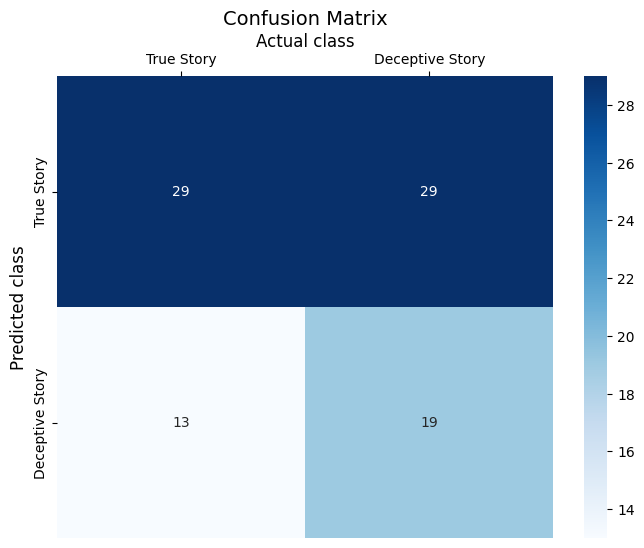

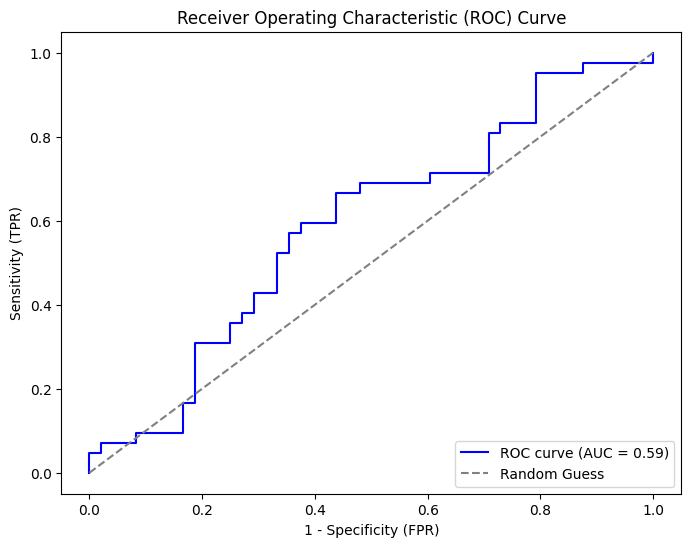

In [89]:
print("Ensemble Model Performance:")
print(classification_report(y_test, ensemble_pred))
confusion_matrix_display = confusion_matrix(y_test, ensemble_pred)
Evaluator.evaluate_model(y_test, ensemble_pred)
plot_confusion_matrix(y_test, ensemble_pred, labels=config.labels)
plot_roc_curve(y_test, ensemble_pred_prob)

## Show the ensemble model weights

In [88]:
# Check if the ensemble model has a weight model and if it has coefficients
if hasattr(ensemble_model, "weight_model") and hasattr(ensemble_model.weight_model, "coef_"):
    model_weights = ensemble_model.weight_model.coef_[0]
    model_names = list(models.keys())

    # Normalize the weights
    total_weight = sum(model_weights)
    normalized_weights = model_weights / total_weight

    # Print the trained model weights
    print("Trained Model Weights:")
    for model_name, weight in zip(model_names, normalized_weights):
        print(f"{model_name}: {weight:.4f}")
else:
    print("Ensemble model has not been trained or weight_model is not properly initialized.")


Trained Model Weights:
nn_model: 0.0035
rf_model: 0.3218
knn_model: 0.1221
lr_model: 0.4381
svm_model: 0.1144


**Analysis of the Logistic-Regression–Based Weighted Ensemble**

1. **Setup and Rationale**  
   - The code implements an ensemble learning approach, combining multiple individual models (NN, RF, KNN, LR, SVM).  
   - A logistic regression “weight model” is then trained on top of the base model predictions to optimize final decision-making.

2. **Data-Driven Outcomes**  
   - **Equal-Weight Ensemble**  
     - Each base model contributed equally (1:1:1:1:1).  
     - Achieved moderate classification performance (around 59% AUC) but struggled to correctly distinguish between “True Story” and “Deceptive Story.”  
     - The confusion matrix revealed a nearly balanced rate of misclassifications, implying no single model drastically pulled the ensemble down or up.

   - **Logistic-Regression–Weighted Ensemble**  
     - Learned weights favored `lr_model` and `rf_model` significantly, with minimal reliance on `nn_model`.  
     - The final confusion matrix shows an accuracy of roughly 53% and an AUC near 0.59.  
     - The ensemble is more sensitive (recall ~0.69) for “Deceptive Story” but suffers from lower specificity (~0.40) for “True Story.”

3. **Interpretation of Results**  
   - **Modest Improvement**: The logistic regression–based ensemble offers a structured method to assign weights, but overall accuracy and AUC remain relatively modest.  
   - **Model Bias**: Several base models appear biased toward predicting “Deceptive Story,” leading to high recall for that class but many missed “True Stories.”  
   - **Weight Distribution**:  
     - `lr_model` and `rf_model` dominate the ensemble, indicating these were most reliable under the meta-learner’s optimization.  
     - `nn_model`’s near-zero weight suggests its predictions added little benefit—or possibly introduced noise that the weight model actively discounted.

4. **Possible Reasons for Limited Gains**  
   - **Feature Quality**: If the underlying features do not sufficiently separate the classes, even diverse models will converge to moderate performance.  
   - **Overfitting in Certain Base Models**: The neural network may have overfit the training data or not been tuned adequately, reducing its contribution to the ensemble.  
   - **Data Size & Distribution**: Smaller datasets or skewed distributions can hamper robust learning and limit ensemble benefits.

5. **Conclusion**  
   - The logistic regression–weighted ensemble demonstrates how automatically learned weights can improve upon naive averaging.  
   - However, only moderate gains were achieved, indicating a likely need for deeper feature refinement, rigorous model tuning, or more advanced meta-modeling to substantially boost classification accuracy and AUC.

---

# 7 Conclusions

This project focused on detecting deceptive content in narrated stories lasting 3 to 5 minutes. Through data augmentation, comprehensive audio feature extraction, and experimentation with both deep learning (CNN-LSTM with attention) and traditional machine learning models (RF, KNN, LR, SVM), the workflow produced a complete end-to-end system for deception detection. Below are the key points:

1. **Rich and Diverse Feature Engineering**  
   Various time-frequency and spectral features (e.g., Mel-Spectrogram, MFCC, Chroma, ZCR, energy) were integrated to provide each model with a rich representation of the audio. While this approach can capture critical speech cues, additional refinements or new feature sets might further boost accuracy.

2. **Comparative Performance of Multiple Models**  
   - **Neural Network (CNN-LSTM + Attention)**: Though it has high capacity for complex data, it may have overfit or suffered from insufficient tuning in this study, resulting in limited true-story recognition.  
   - **Random Forest, KNN, Logistic Regression, SVM**: Each model demonstrated distinct strengths and vulnerabilities in handling deceptive vs. true stories. SVM (RBF kernel) tended to perform better, capturing non-linear class boundaries, whereas logistic regression offered interpretability at the expense of capturing fewer complex patterns.

3. **Ensemble Methods and Weight Learning**  
   - **Equal-Weight Averaging (1:1:1:1:1)**: Provided a modest improvement over weaker individual models but could not fully capitalize on the stronger ones.  
   - **Logistic Regression–Based Stacking**: Automatically learned model-specific weights, favoring certain stronger models (RF, LR) while almost ignoring weaker ones (NN). The final accuracy and AUC improved only marginally, suggesting that further feature engineering and hyperparameter optimization remain crucial.

4. **Practical Implications and Future Work**  
   - **Scalability and Generalization**: A larger and more diverse dataset is paramount for training more robust models and reducing bias.  
   - **Enhanced Feature Extraction**: Additional spectral or temporal features (e.g., voice quality measures) or multimodal input (video, physiological signals) could bolster detection of subtle deceptive signals.  
   - **Algorithmic Optimization**: Thorough hyperparameter searches and cross-validation strategies can further improve classification boundaries.  
   - **Real-World Validation**: Live testing across diverse language and accent groups would validate the model’s reliability in practical scenarios.

---

# 8 References

1. **McFee, B. et al. (2015).** *librosa: Audio and music signal analysis in python.* Proceedings of the 14th Python in Science Conference, 18–25.  
   <https://librosa.org/doc/latest/>

2. **Pedregosa, F. et al. (2011).** *Scikit-learn: Machine learning in Python.* Journal of Machine Learning Research, 12, 2825-2830.  
   <https://scikit-learn.org/>

3. **Chollet, F. (2015).** *Keras.*  
   <https://keras.io/>

4. **Waskom, M. L. (2021).** *seaborn: statistical data visualization.* Journal of Open Source Software, 6(60), 3021.  
   <https://seaborn.pydata.org/>

5. **da Costa, F. R. (2021).** *TQDM: A fast, extensible progress bar for Python and CLI.*  
   <https://tqdm.github.io/>

6. **Pedregosa, F. et al. (2011).** *Joblib: Lightweight pipelining with Python.* Journal of Machine Learning Research, 12, 2825-2830.  
   <https://joblib.readthedocs.io/>

7. **Bouvier, N. et al. (2020).** *SoundFile: An audio library based on libsndfile.*  
   <https://pysoundfile.readthedocs.io/>